# Prosper Loan Data Exploration
## by Vilija Vaitkeviciute

## Preliminary Wrangling

The loan data from [Prosper](https://www.prosper.com/), an online lending platform that connects people who want to borrow money with individuals and institutions, is explored here.  The loan data includes loan characteristics, Prosper's internal tracking data, borrower profile and some lender information.

The analysis will focus on
- understanding how the lender's estimated returns relate to various factors, and 
- how the estimated returns available from loans have evolved over time. 

Theis question is of interest to potential lenders, who may not be familiar with loan pricing mechanism, or even to auditors and competitors.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="white")

In [2]:
# load dataset
df = pd.read_csv('prosperLoanData.csv')
df.head()

ListingKey  ListingNumber            ListingCreationDate  \
0  1021339766868145413AB3B         193129  2007-08-26 19:09:29.263000000   
1  10273602499503308B223C1        1209647  2014-02-27 08:28:07.900000000   
2  0EE9337825851032864889A          81716  2007-01-05 15:00:47.090000000   
3  0EF5356002482715299901A         658116  2012-10-22 11:02:35.010000000   
4  0F023589499656230C5E3E2         909464  2013-09-14 18:38:39.097000000   

  CreditGrade  Term LoanStatus           ClosedDate  BorrowerAPR  \
0           C    36  Completed  2009-08-14 00:00:00      0.16516   
1         NaN    36    Current                  NaN      0.12016   
2          HR    36  Completed  2009-12-17 00:00:00      0.28269   
3         NaN    36    Current                  NaN      0.12528   
4         NaN    36    Current                  NaN      0.24614   

   BorrowerRate  LenderYield  ...  LP_ServiceFees  LP_CollectionFees  \
0        0.1580       0.1380  ...         -133.18                0.0   
1        0.0920       0.0820  ...            0.00                0.0   
2        0.2750       0.2400  ...          -24.20                0.0   
3        0.0974       0.0874  ...         -108.01                0.0   
4        0.2085       0.1985  ...          -60.27                0.0   

   LP_GrossPrincipalLoss  LP_NetPrincipalLoss LP_NonPrincipalRecoverypayments  \
0                    0.0                  0.0                             0.0   
1                    0.0                  0.0                             0.0   
2                    0.0                  0.0                             0.0   
3                    0.0                  0.0                             0.0   
4                    0.0                  0.0                             0.0   

   PercentFunded  Recommendations InvestmentFromFriendsCount  \
0            1.0                0                          0   
1            1.0                0                          0   
2            1.0                0                          0   
3            1.0                0                          0   
4            1.0                0                          0   

  InvestmentFromFriendsAmount Investors  
0                         0.0       258  
1                         0.0         1  
2                         0.0        41  
3                         0.0       158  
4                         0.0        20  

[5 rows x 81 columns]

In [3]:
df.shape

(113937, 81)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
ListingKey                             113937 non-null object
ListingNumber                          113937 non-null int64
ListingCreationDate                    113937 non-null object
CreditGrade                            28953 non-null object
Term                                   113937 non-null int64
LoanStatus                             113937 non-null object
ClosedDate                             55089 non-null object
BorrowerAPR                            113912 non-null float64
BorrowerRate                           113937 non-null float64
LenderYield                            113937 non-null float64
EstimatedEffectiveYield                84853 non-null float64
EstimatedLoss                          84853 non-null float64
EstimatedReturn                        84853 non-null float64
ProsperRating (numeric)                84853 non-null float64
ProsperRating (Alpha) 

In [5]:
#converting all dates to datetime
df.ListingCreationDate = pd.to_datetime(df.ListingCreationDate)
df.LoanOriginationDate = pd.to_datetime(df.LoanOriginationDate)
df.DateCreditPulled = pd.to_datetime(df.DateCreditPulled)
df.ClosedDate = pd.to_datetime(df.ClosedDate)

In [6]:
# LoanStatus into ordered categorical type
loanstatus_order = ['Current', 'FinalPaymentInProgress', 'Completed',  'Past Due (1-15 days)',
                    'Past Due (16-30 days)', 'Past Due (31-60 days)', 'Past Due (61-90 days)', 
                    'Past Due (91-120 days)', 'Past Due (>120 days)', 'Defaulted',
                    'Chargedoff']

ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = loanstatus_order)
df.LoanStatus = df.LoanStatus.astype(ordered_var)

Dictionary of variables mentions a change in loan data applicable for loans originated after July 2009; this includes calculations of Effective Yield, Estimated Loss and Effective Return, key variables to be analysed.  Therefore, I will drop the loan listings that occure before July 2009.  Before doing this, I will check the loan listing distribution accross time, to ensure there will be sufficient remaining data for the proposed analysis.

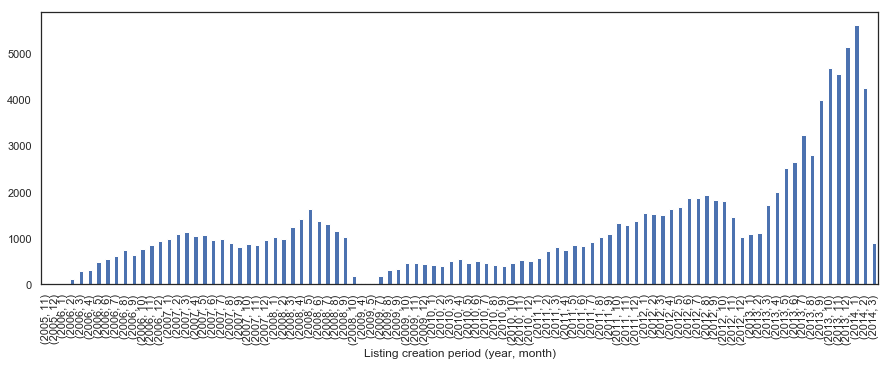

In [7]:
plt.figure(figsize=[15,5])
df.groupby([df.ListingCreationDate.dt.year,df.ListingCreationDate.dt.month])['ListingCreationDate'].count().plot(kind='bar')
plt.xlabel('Listing creation period (year, month)');

There appears to be sufficient data for analysis for post July 2009 period.  Will drop earlier observations (in line when first EstimatedReturn is recorded).

In [8]:
min_date = min(df[~df.EstimatedReturn.isnull()].ListingCreationDate)
min_date

Timestamp('2009-07-13 18:01:24.347000')

In [9]:
df = df[df.ListingCreationDate>= min_date]
df.shape

(84853, 81)

As the dataset contains 81 variables, I will create a correlation matrix for the numeric variables, in order to make a preliminary decision as to which set of variables are likely to relate to variables of interest.

This will not be conclusive analysis, because, among others:
- linear correlation is not the only type of relashionship, 
- this excludes any categorical variables,
- in cases where relationship between variables is expected, but corr. coefficient is low, it is interesting to dig further.

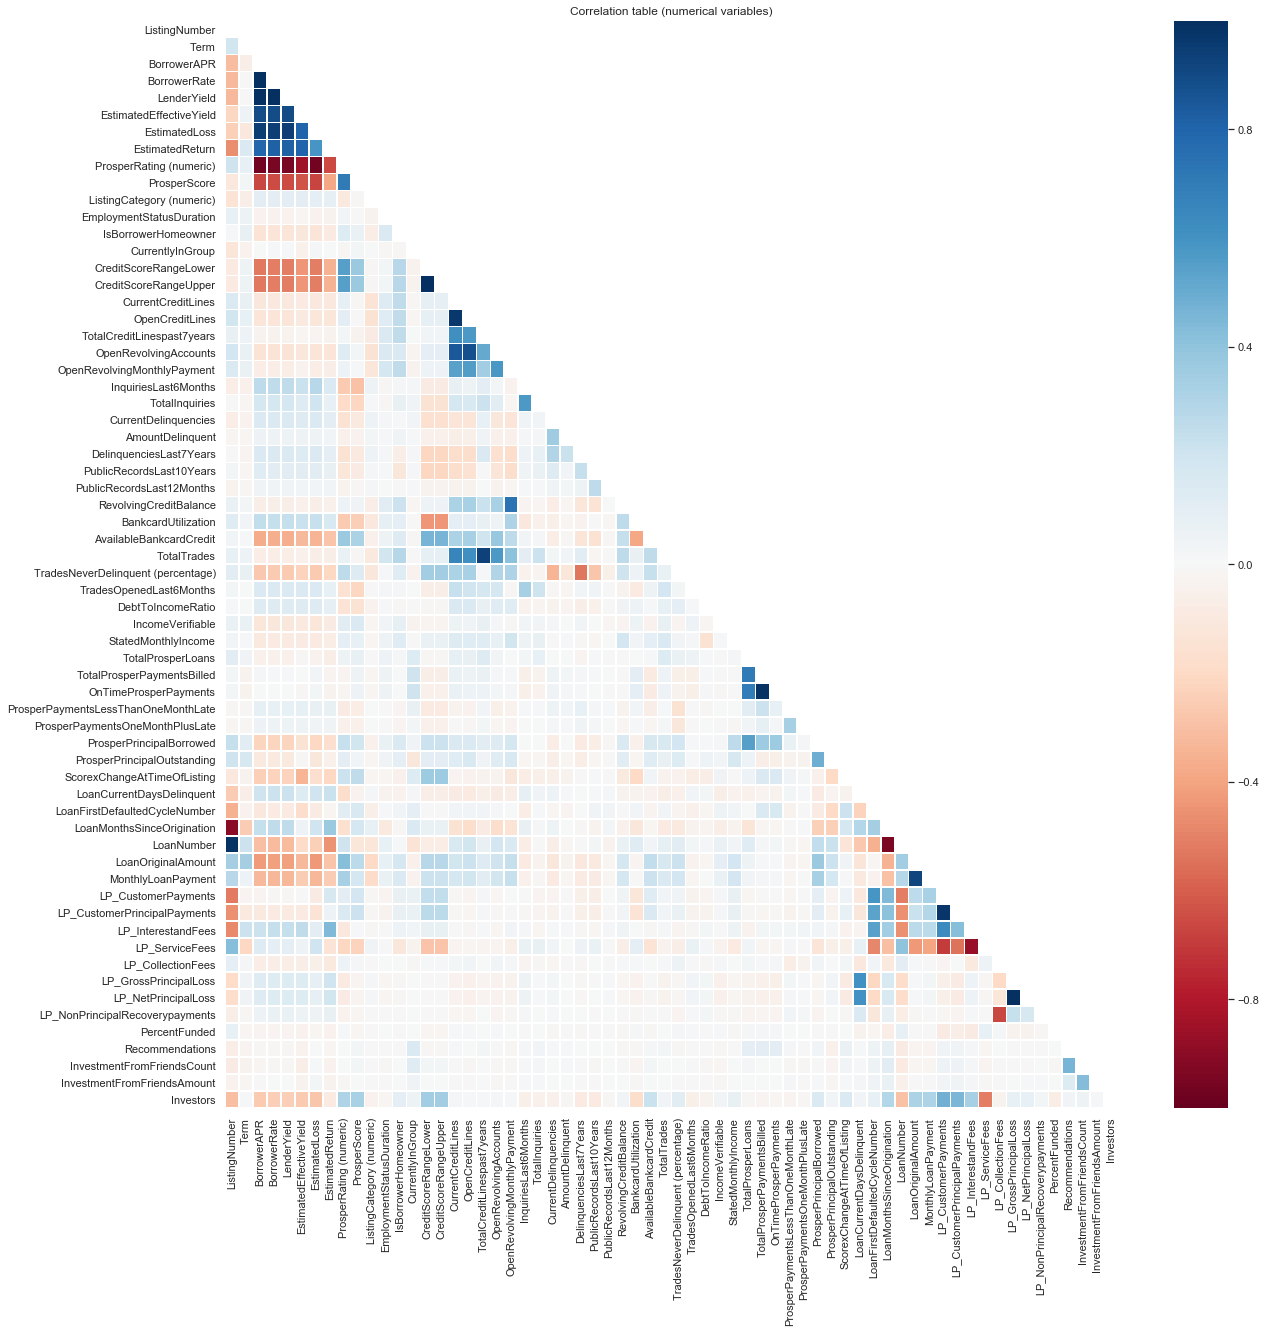

In [10]:
#lets check correlations of all numeric variables
plt.figure(figsize=[20,20])

#compute correlations
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot heatmap
sns.heatmap(corr, cmap = 'RdBu', vmin = -1, vmax = 1, mask=mask, linewidths=0.5)
plt.title('Correlation table (numerical variables)');

### What is the structure of your dataset?

There are 84,853 observations in the dataset (abreviated to include only post 13-July-2009 observations), where 13-July-2009 marks introduction of EstimatedReturn, EstimatedLoss, Estimated Yield, ProsperScore and other key variables to the analysis.

The dataset contains 81 features, of which majority are numerical (61), categorical (17) and boolean (3); some of the numerical variables are numerical categories or ratings (such as 'ProsperRating (numeric)', ListingCategory, ProsperScore). 

### What is/are the main feature(s) of interest in your dataset?

The analysis will focus on
- understanding how the lender's estimated returns relate to various factors, and 
- how the estimated returns available from loans have evolved over time. 

Theis question is of interest to potential lenders, who may not be familiar with loan pricing mechanism, or even to auditors and competitors.  

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

#### Variables correlated with EstimatedReturn (on linear basis):
The following are numerical variables with higher absolute correlation coefficients with estimated lender return, categorised:
- EstimatedReturn components (estimates/actuals) ('EstimatedEffectiveYield', 'EstimatedLoss', 'LP_NetPrincipalLoss'),
- Borrower's current and historical need/utisation of credit facilities ('InquiriesLast6Months', 'CurrentDelinquencies', 'DelinquenciesLast7Years', 'BankcardUtilization', 'AvailableBankCardCredit'),
- Borrower's credit score as provided by external agencies ('CreditScoreRangeLower', 'CreditScoreRangeUpper'),
- Borrower's income profile ('DebtToIncomeRatio', 'StatedMonthlyIncome', 'MonthlyLoanPayment', 'IsBorrowerHomeowner'),
- Loan's properties ('LoanOriginalAmount', 'Term', 'ListingCategory (numeric)', 'LoanStatus') 

##### Except:
Few variables, that are highly correlated such as :
- BorrowerRate, BorrowerAPR are excluded, as they are expected to be linear to EstimatedReturns (e.g. in this case, difference should be Prosper's margin).
- LoanNumber, which is "a unique numeric value associated with a loan", and appears to represent internal loan tracking number
- LP_ServiceFees - various return components, that should be minor and/or constant accross loans (and could be investigated in broader scope examination)
- LP_InterestandFees - applicable only to defaulted loans, and should be related formulaically to loan yield and amount (and could be investigated in broader scope examination)

#### Further variables
Additional variables (non numerical) to be included in analysis:
- date variables for time trends analysis, which in any, especially financial data is of importance ('ListingCreationDate', 'ClosedDate', 'LoanOriginationDate')
- categorical variables, which were not included in correlation analysis ('Occupation')
- variables that will need to be transformed, e.g because being abslute variables, perhaps could not have produced linear correlation with EstimatedReturns (e.g 'InvestmentFromFriendsAmount' and 'LoanOriginalAmount' can be used to calculate % of loan funded by friends)

## Univariate Exploration

### EstimatedReturn components (estimates)

Plot histograms of main return components, Estimated Effective Return, Yield and Loss.  

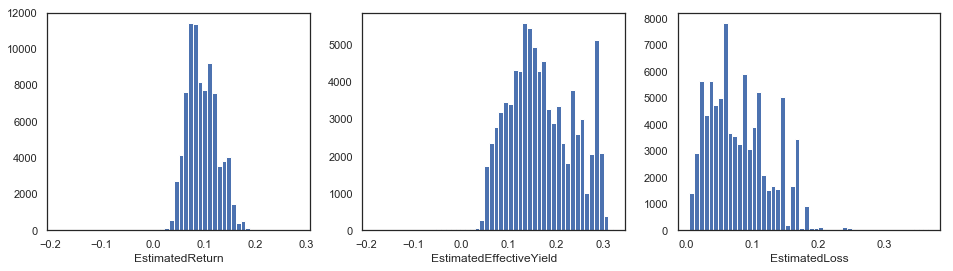

In [72]:
columns = 3
fig, ax = plt.subplots(ncols=columns, figsize = [16,4])
variables = ['EstimatedReturn', 'EstimatedEffectiveYield', 'EstimatedLoss']

for j in range(columns):
    var = variables[j]
    ax[j].hist(df[var], bins=50)
    ax[j].set_xlabel('{}'.format(var))

df[df.EstimatedReturn < 0]['ListingKey'].count(), df[df.EstimatedEffectiveYield < 0]['ListingKey'].count()

They appear to be range bound, in particular, some Returns and Yields fall into negative territory (expected because these are defaulted or chargedoff loans).  Will check how many fall into this category.

In [12]:
df[df.EstimatedReturn < 0]['ListingKey'].count(), df[df.EstimatedEffectiveYield < 0]['ListingKey'].count()

(195, 190)

Will replot the histograms excluding these cases, as out of >80,000 these are only ca. 200 cases.

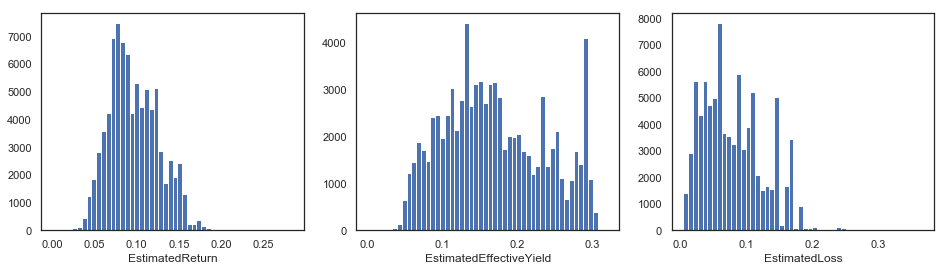

In [73]:
columns = 3
fig, ax = plt.subplots(ncols=columns, figsize = [16,4])
variables = ['EstimatedReturn', 'EstimatedEffectiveYield', 'EstimatedLoss']

for j in range(columns):
    var = variables[j]
    ax[j].hist(df[var][df[var]>0], bins=50)
    ax[j].set_xlabel('{}'.format(var))

- The Estimated Return distribution is bell shaped,  
- Estimated Effective yield distribution is also bell shaped, with smaller local modes on the right tale, 
- Estimated Loss is skewed to the right. 

### Loss (estimated/actual)

Brief check how estiamted loss related to actual loss:
- will look at count and proportion of loans that contained losses,
- compute at look at distribution of loss ratio (LP_NetPrincipalLoss over LoanOriginalAmount)

In [74]:
print(df.LP_NetPrincipalLoss[df.LP_NetPrincipalLoss == 0].count())
print(df.LP_NetPrincipalLoss[df.LP_NetPrincipalLoss != 0].count())
print(df.LP_NetPrincipalLoss[df.LP_NetPrincipalLoss != 0].count()/df.LP_NetPrincipalLoss.count())

78670
6183
0.07286719385289854


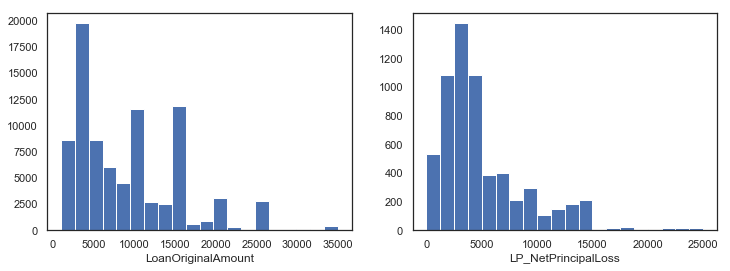

In [15]:
columns = 2
fig, ax = plt.subplots(ncols=columns, figsize = [6*columns,4])

variables = ['LoanOriginalAmount', 'LP_NetPrincipalLoss']

for j in range(columns):
    var = variables[j]
    ax[j].hist(df[var][df[var]>0], bins=20)
    ax[j].set_xlabel('{}'.format(var));

In [16]:
df['LoanLossRatio'] = df.LP_NetPrincipalLoss/df.LoanOriginalAmount

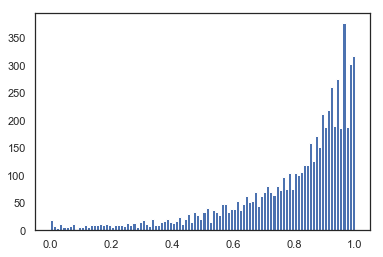

In [17]:
plt.figure(figsize = [6,4])
plt.hist(df.LoanLossRatio[(df.LoanLossRatio > 0)], bins=100);

Loan loss ratio is distributed betweet 0 and 1 (in contract to estimated losses, distributed between 0 and 0.3), and is skewed to the left.

### Borrower's current and historical need/utisation of credit facilities


Plot histograms of variables that relate to borrowers' current need of credit facilities (inquiries over last 6 months, bank card utilisation, available bank credit), and their current and historic utilisation/behavior wiht credit facilities (current delinquencies, delinquencies of the last 7 years).

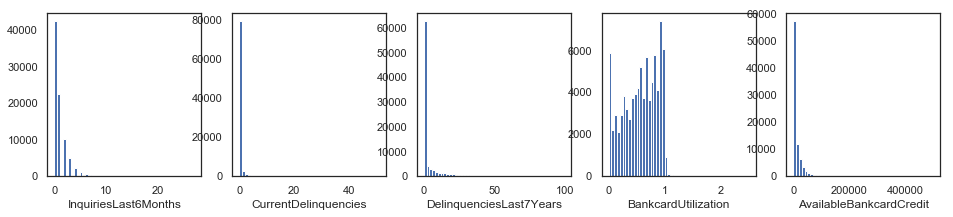

In [18]:
columns = 5
fig, ax = plt.subplots(ncols=columns, figsize = [16,3])
variables = ['InquiriesLast6Months', 'CurrentDelinquencies', 'DelinquenciesLast7Years', 
             'BankcardUtilization', 'AvailableBankcardCredit']

for j in range(columns):
    var = variables[j]
    ax[j].hist(df[var], bins=50)
    ax[j].set_xlabel('{}'.format(var))

Here replot the histograms with reduced bin size and excluding zero value on first row, and with log scale on second row.  Log scale motivated by the fact that all variables except BankcardUtilization are heavily skewed to the right, and by plotting on log scale, will be better able to distinguish the shape of the distribution.

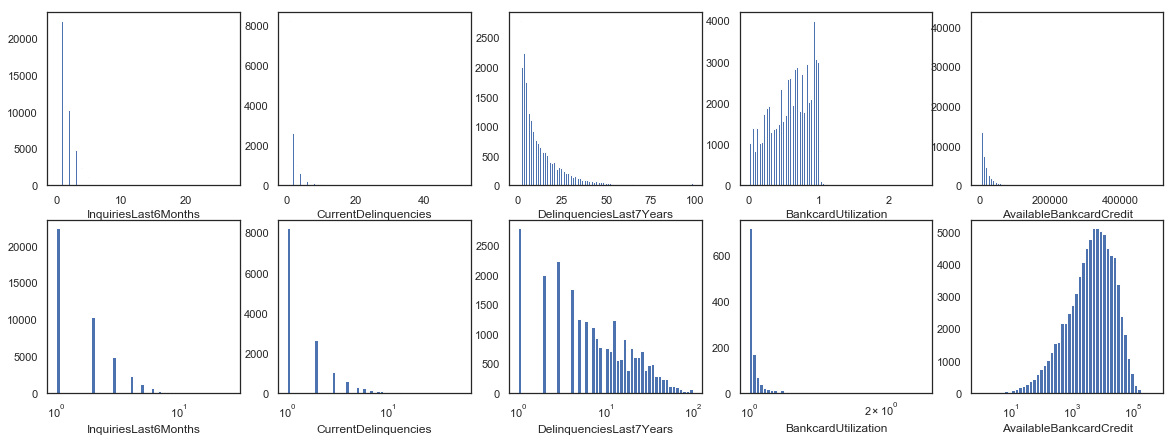

In [19]:
columns = 5
rows = 2
fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize = [columns*4,rows*3.5])
variables = ['InquiriesLast6Months', 'CurrentDelinquencies', 'DelinquenciesLast7Years', 
             'BankcardUtilization', 'AvailableBankcardCredit']

for i in range(rows):
    for j in range(columns):
        var = variables[j]
        step = max(df[var])/100
        bins = np.arange(0,max(df[var])+step,step)
        if i==1:
            step = np.log10(df[var].max())/50
            bins = 10 ** np.arange(0, np.log10(df[var].max())+step, step)
            ax[i, j].set_xscale('log')
        ax[i,j].hist(df[var][(df[var] > 0)], bins=bins)
        ax[i, j].set_xlabel('{}'.format(var))    

- Inquiries in the last 6 months and CurrentLelinquncies (count) are largely distributed between 1 and 10;
- Delinquncies over last 6 years are largely distributed between 1 and 100, and are skewed to the right;
- Available bank card credit is bell shaped on log scale, with peak around 10,000 and skewed to the left.

### Borrower's credit score as provided by external agencies 

Plot histograms of credit score lower and upper range, examine the correlation between the two, and if highly correlated, merge into one variable.

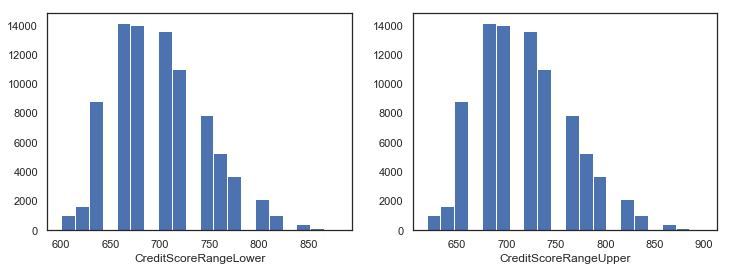

In [20]:
columns = 2
fig, ax = plt.subplots(ncols=columns, figsize = [6*columns,4])

variables = ['CreditScoreRangeLower', 'CreditScoreRangeUpper']

for j in range(columns):
    var = variables[j]
    ax[j].hist(df[var], bins=20)
    ax[j].set_xlabel('{}'.format(var))

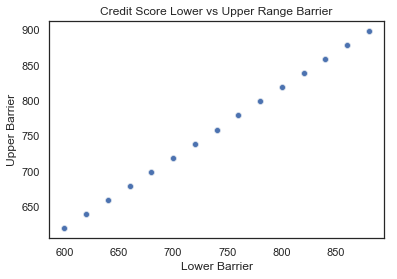

In [21]:
sns.scatterplot(data=df, x='CreditScoreRangeLower', y='CreditScoreRangeUpper', alpha = 0.5)
plt.title("Credit Score Lower vs Upper Range Barrier")
plt.xlabel("Lower Barrier")
plt.ylabel("Upper Barrier");

The credit score lower and upper range have bell shaped distributions, slightly skewed to the right.
The credit score lower and upper range appear to be perfectly correlated; I will therefore compute a new single variable Credit Score Mid, that is a mean of the two variables.

In [22]:
df['CreditScoreMid'] = (df.CreditScoreRangeUpper+df.CreditScoreRangeLower)/2

In [77]:
df.CreditScoreMid.mean()

708.8902395908218

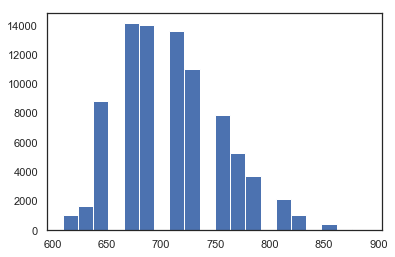

In [76]:
plt.hist(df.CreditScoreMid, bins=20);

### Borrower's income profile

Plot histograms of variables that relate to borrowers' income profile and affordability of the loan, including Debt To Income Ratio, Stated Monthly Income, Monthly Loan Payment, Is Borrower Homeowner.

Below I plot side by side a histogram for full range of values on the left, and zooming into where majority of values for debt to income ratio are in the range of 0 to 2.

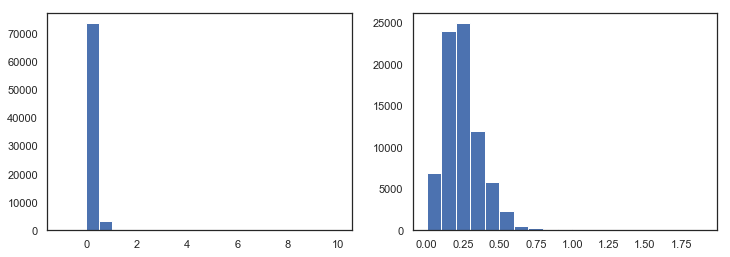

In [80]:
fig, ax=plt.subplots(ncols=2, figsize=(2*6,4))

bins = np.arange(-1,max(df.DebtToIncomeRatio),0.5)
ax[0].hist(df.DebtToIncomeRatio, bins=bins)

bins = np.arange(0,2,0.1)
ax[1].hist(df.DebtToIncomeRatio, bins=bins);

Debt to income ratio distribution is bell shaped and skewed to the right.

Below plotting unadjusted histogram for stated monthly income.

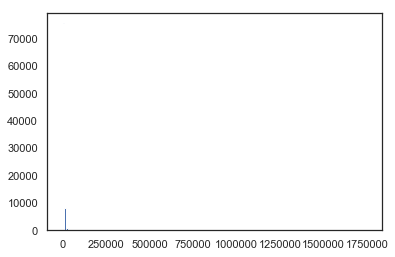

In [24]:
plt.figure(figsize = [6,4])
bins = np.arange(-1,max(df.StatedMonthlyIncome),10000)
plt.hist(df.StatedMonthlyIncome, bins=bins);

There appear to be some outliers (with stated income in the range from 50,000 to 1,750,000).  I will check the count of such outliers.

In [25]:
df.StatedMonthlyIncome[df.StatedMonthlyIncome > 50000].count()

61

In [26]:
df.StatedMonthlyIncome.describe()

count    8.485300e+04
mean     5.931175e+03
std      8.239944e+03
min      0.000000e+00
25%      3.434000e+03
50%      5.000000e+03
75%      7.083333e+03
max      1.750003e+06
Name: StatedMonthlyIncome, dtype: float64

There are only very few of such outliers, with mean being 5,000.  Reploting the histogram now withing 0 to 50,000 range.

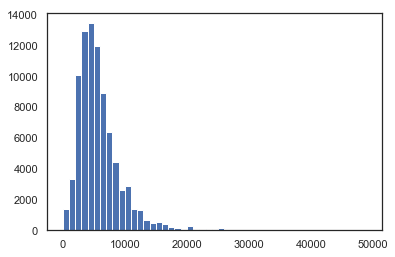

In [81]:
bins = np.arange(0,50000,1000)
plt.hist(df.StatedMonthlyIncome, bins=bins);

Stated monthly income distribution is bell shaped and skewed to the right. 

Below I plot side by side a histogram for full range of values on the left, and zooming into where majority of values for monthly loan payment in the range of 0 to 1500.

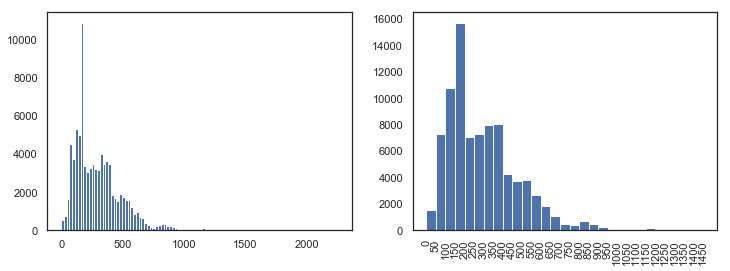

In [28]:
fig, ax=plt.subplots(ncols=2, figsize=(2*6,4))

ax[0].hist(df.MonthlyLoanPayment, bins=100)

bins = np.arange(0,1500, 50)
ax[1].hist(df.MonthlyLoanPayment, bins=bins)
ax[1].set_xticks(bins)
ax[1].set_xticklabels(bins,rotation = 90);

Monthly loan payment distribution is bell shaped and skewed to the right,  also notable is relatively flat middle between USD 100 and USD 400m and spike near USD 200 monthly payments.

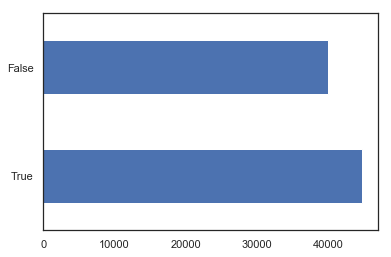

In [29]:
df.IsBorrowerHomeowner.value_counts().plot(kind='barh', figsize=[6,4]);

There are more homeowners than non homeowners in the dataset.

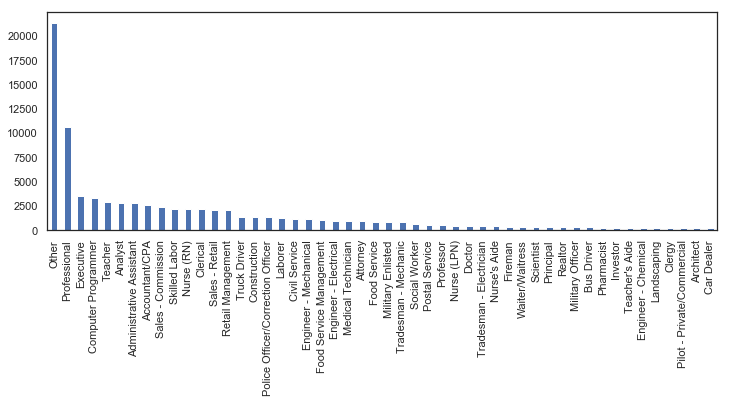

In [30]:
df.Occupation.value_counts().head(50).plot(kind='bar', figsize = [12,4]);

There is a wide range of occupations stated especially highlighted by the fact that "other" is the largest catefory, and not one clearly defined occupation.

### Properties of the loan

Plot histograms of loan properties, including Loan Status, Loan Amount, Term and Listing Category (numeric).

Plot all loan category counts on the left, and on the right plot all categories that certainly relate to non-performing loans. 

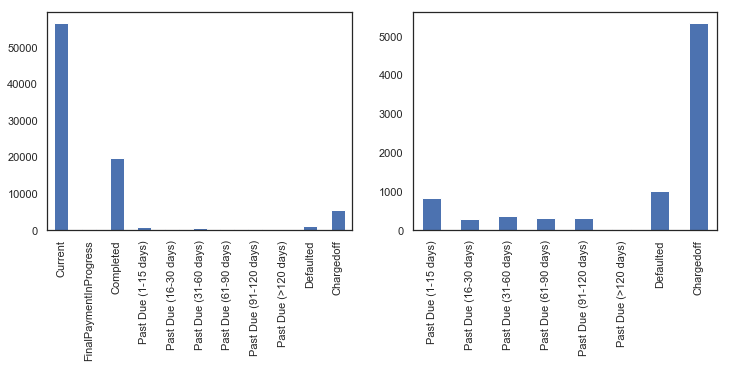

In [35]:
fig, ax=plt.subplots(ncols=2, figsize=(2*6,4))

df['LoanStatus'].value_counts().sort_index().plot(kind='bar', ax=ax[0])
df['LoanStatus'].value_counts().sort_index()[3:].plot(kind='bar', ax=ax[1]);

Most of loans are in Current and Completed category, also notable that there are over 5000 charged off loans.

Below I plot side by side a histogram for full range of values on the left, and increasing bin size (because it appears that loan amount is not continious, thus good visibility over distribution also seen with larger bins) for loan original amount on the right.

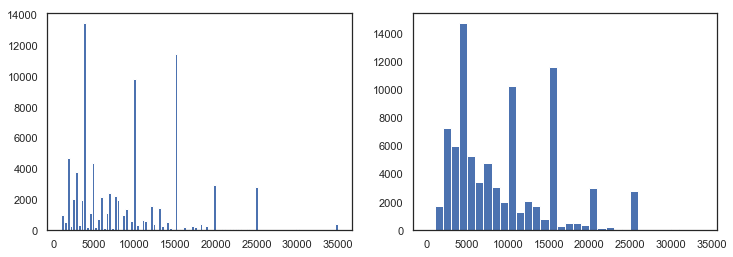

In [32]:
fig, ax=plt.subplots(ncols=2, figsize=(2*6,4))

ax[0].hist(df.LoanOriginalAmount, bins=100)

bins = np.arange(0,35000,1000)
ax[1].hist(df.LoanOriginalAmount, bins=bins);

The loan sizes are bell shaped, with notable spikes at around 5000, 10000, 15000, 20000 and 25000, and skewed to the right.

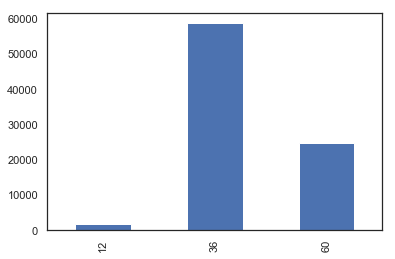

In [33]:
df.Term.value_counts().sort_index().plot(kind='bar', figsize=[6,4]);

There are only three types of terms, and with 36 month most popular, 60 month loans still numerous, far fewer 12 month term loans.

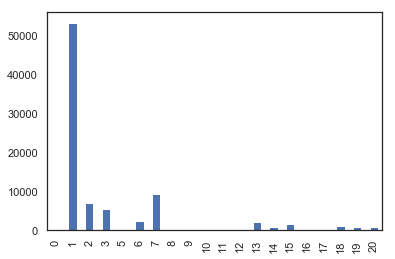

In [34]:
df['ListingCategory (numeric)'].value_counts().sort_index().plot(kind='bar', figsize = [6,4]);

Most loans are listed under 1- Debt Consolidation category, and other categories being far less frequent. 

### Date variables

Plot distributions of loan counts accross time for date variables,including Listing Creation Date, Closed Date and Loan Origination Date.

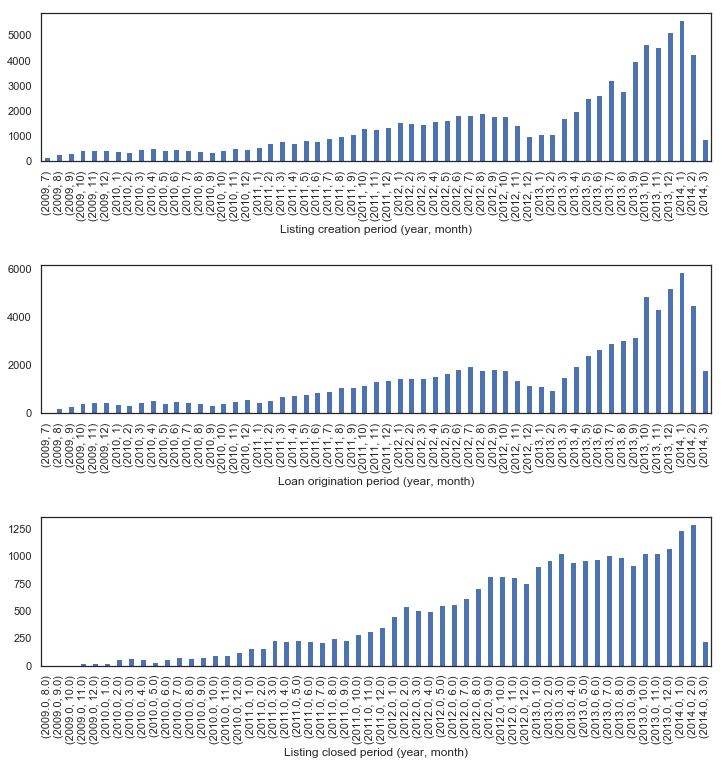

In [36]:
fig, ax = plt.subplots(nrows=3, figsize=[12,12])

df.groupby([df.ListingCreationDate.dt.year,df.ListingCreationDate.dt.month])['ListingCreationDate'].count().plot(kind='bar', 
                                                                                                                 ax=ax[0])
ax[0].set_xlabel('Listing creation period (year, month)')

df.groupby([df.LoanOriginationDate.dt.year,df.LoanOriginationDate.dt.month])['LoanOriginationDate'].count().plot(kind='bar', 
                                                                                                                 ax=ax[1])
ax[1].set_xlabel('Loan origination period (year, month)')

df.groupby([df.ClosedDate.dt.year,df.ClosedDate.dt.month])['ClosedDate'].count().plot(kind='bar', 
                                                                                      ax=ax[2])
ax[2].set_xlabel('Listing closed period (year, month)')

plt.subplots_adjust(hspace=0.7);

Analyse the gap between loan origination date and listing creation date.

Plot histograms of the gap between the dates (which represents time during which loans would presumably have been warehoused by Prosper), on the left without ardjustment, and on the right on the log scale.

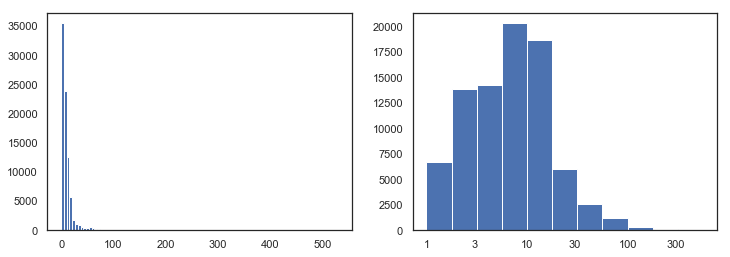

In [83]:
warehouse_range = (df.LoanOriginationDate - df.ListingCreationDate).dt.days

fig, ax=plt.subplots(ncols=2, figsize=(2*6,4))

ax[0].hist(warehouse_range, bins=100);

step = 0.25
bins = 10**np.arange(0, np.log10(warehouse_range.max())+step, step)
ax[1].hist(warehouse_range, bins=bins)
ax[1].set_xscale('log')
plt.xticks([1,3,10,30,100,300], [1,3,10,30,100,300]);

In [38]:
warehouse_range.describe()

count    84853.000000
mean        10.689133
std         17.708353
min          0.000000
25%          3.000000
50%          7.000000
75%         12.000000
max        529.000000
dtype: float64

Looks like mean loan warehousing day range is 7 days, with upper interquartile range being 12 days.  For my analysis, which will focus on return/yield on loans progression over the years, this is not a significant gap, thus I will continue using Listing Creation Date as the main date variable.  

### Other variables

Will examine the investment from friends - by checking the total number of loans that contain such investment, and, for those loans that do, the distribution of proportion invested by friends.

In [39]:
print(df.InvestmentFromFriendsAmount[df.InvestmentFromFriendsAmount == 0].count())
print(df.InvestmentFromFriendsAmount[df.InvestmentFromFriendsAmount > 0].count())

84267
586


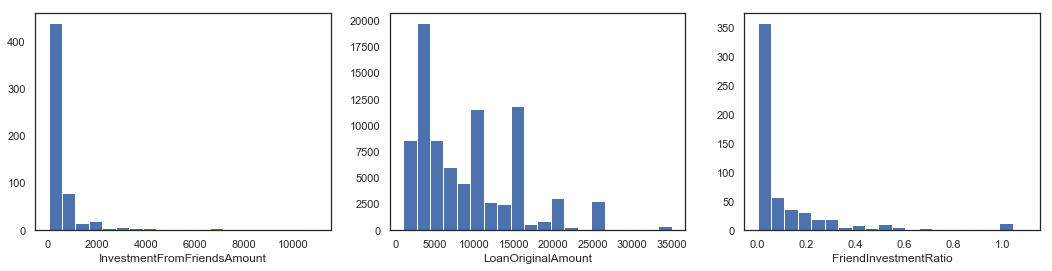

In [40]:
columns = 3
fig, ax = plt.subplots(ncols=columns, figsize = [6*columns,4])

df['FriendInvestmentRatio'] = df.InvestmentFromFriendsAmount / df.LoanOriginalAmount

variables = ['InvestmentFromFriendsAmount', 'LoanOriginalAmount', 'FriendInvestmentRatio']

for j in range(columns):
    var = variables[j]
    ax[j].hist(df[var][df[var]>0], bins=20)
    ax[j].set_xlabel('{}'.format(var))

It appears that very few loans include investment by friends, and for those the proportion loan amount lent by friends is small, and highly skewed to the right.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

Due to a large numberber of variables analysed, each variable's distribution is discussed separatelly near its individual chart above.

Large number of variables have a bell shaped distributions (including the dependent variables -- estimated returns, yield, loss -- and including independent variables of available bank credit (on log scale), borrower's credit score, debt to income ratio, stated monthly income and others), and majority have skewed distributions with long tails.  

The data contains outliers, including:
- negative yield loans, 
- some borrower's having made outsized number of inquiried in the last 6 months,
- some borrower's having outsized number of delinquencies,
- very large stated monthly incomes,
- very large available bankcard credit.
and generally many variables are skewed and have long tails.

I looked at several variables on the log scale, due to existence of the long tails in their distribution, and the following variables:
- inquiries in the last six months, current and part 7 years delinquencies and bankcard credit availability. 

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

The main transformation of data was to reduce the size of the dataset, taking loans from July 2019 onwards, due to dependent variable only being available since this date, and at the same time, there being sufficient observations (84,853) remaining for the analysis.

Created a new variable CreditScoreMid, which is a mean of lower and upper range of credit score.  Lower and upper range of credit score as these were highly positively correlated, thus combining them into one variable implies no loss of accurancy.

Analysed the gap between loan origination date and loan listing date, including use of computing the gap and log transforming it for plotting of its distribution, and concluded that the gap was not significant for the further investigation.

Noted loan sizes while bell shaped have notable spikes at around 5000, 10000, 15000, 20000 and 25000, and are skewed to the right, implying significantly more smaller loans issued than larger ones.


## Bivariate Exploration

Bivariate exploration will focus on bivariate relationship between the dependent variables (Estimated Return, Yield and Loss) and each dependent variable.  

Bivariate exploration will also include exploration of relationship between the three dependent variables (Estimated Return, Yield and Loss).

Furthermore, bivariate exploration will look at other relationships of interest between dependent and independent variables.

In [84]:
# First, will reduce the size of the dataframe analysed to a set containing variables of interest
df = df[['EstimatedReturn', 'EstimatedEffectiveYield',  'EstimatedLoss', 
         'LP_NetPrincipalLoss', 'LoanOriginalAmount', 'LoanLossRatio',
         'InquiriesLast6Months', 'CurrentDelinquencies', 'DelinquenciesLast7Years', 
         'BankcardUtilization', 'AvailableBankcardCredit', 
         'CreditScoreMid',  
         'DebtToIncomeRatio', 'StatedMonthlyIncome', 'MonthlyLoanPayment', 'IsBorrowerHomeowner', 'Occupation',
         'Term', 'ListingCategory (numeric)', 'LoanStatus',
         'ListingCreationDate', 'LoanOriginationDate', 'ClosedDate',
         'InvestmentFromFriendsAmount', 'FriendInvestmentRatio']]

In [42]:
df.columns

Index(['EstimatedReturn', 'EstimatedEffectiveYield', 'EstimatedLoss',
       'LP_NetPrincipalLoss', 'LoanOriginalAmount', 'LoanLossRatio',
       'InquiriesLast6Months', 'CurrentDelinquencies',
       'DelinquenciesLast7Years', 'BankcardUtilization',
       'AvailableBankcardCredit', 'CreditScoreMid', 'DebtToIncomeRatio',
       'StatedMonthlyIncome', 'MonthlyLoanPayment', 'IsBorrowerHomeowner',
       'Occupation', 'Term', 'ListingCategory (numeric)', 'LoanStatus',
       'ListingCreationDate', 'LoanOriginationDate', 'ClosedDate',
       'InvestmentFromFriendsAmount', 'FriendInvestmentRatio'],
      dtype='object')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84853 entries, 1 to 113936
Data columns (total 25 columns):
EstimatedReturn                84853 non-null float64
EstimatedEffectiveYield        84853 non-null float64
EstimatedLoss                  84853 non-null float64
LP_NetPrincipalLoss            84853 non-null float64
LoanOriginalAmount             84853 non-null int64
LoanLossRatio                  84853 non-null float64
InquiriesLast6Months           84853 non-null float64
CurrentDelinquencies           84853 non-null float64
DelinquenciesLast7Years        84853 non-null float64
BankcardUtilization            84853 non-null float64
AvailableBankcardCredit        84853 non-null float64
CreditScoreMid                 84853 non-null float64
DebtToIncomeRatio              77557 non-null float64
StatedMonthlyIncome            84853 non-null float64
MonthlyLoanPayment             84853 non-null float64
IsBorrowerHomeowner            84853 non-null bool
Occupation                     

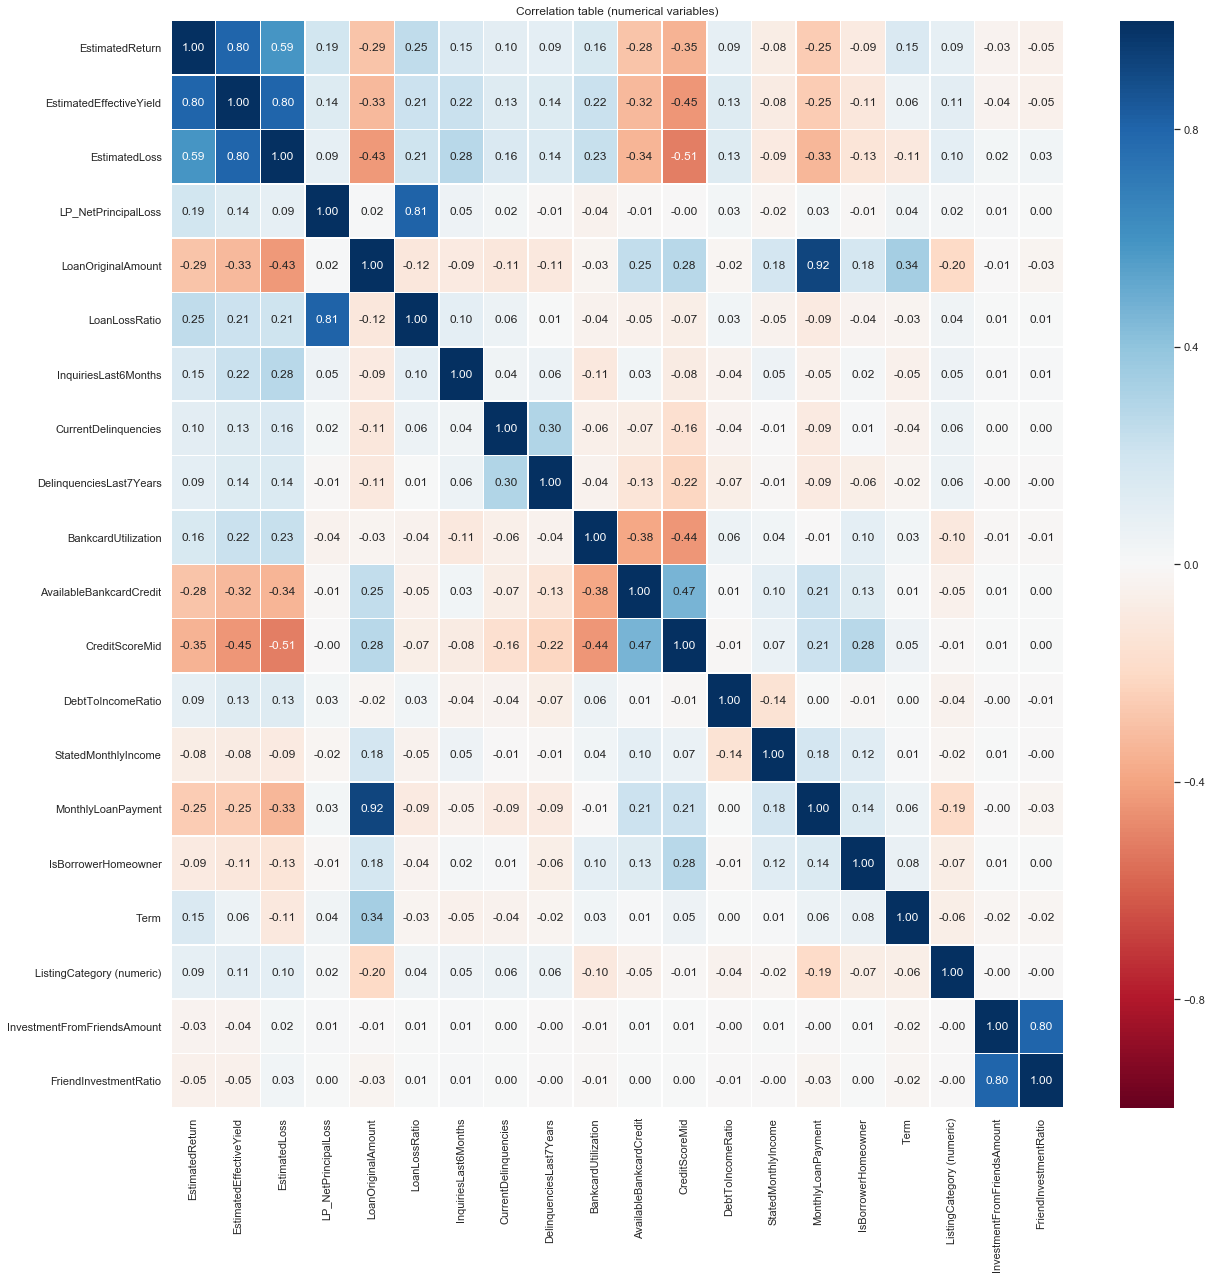

In [85]:
#lets check correlations of all numeric variables in now reduced dataset
plt.figure(figsize=[20,20])

#compute correlations
corr = df.corr()

# Plot heatmap
sns.heatmap(corr, cmap = "RdBu", vmin = -1, vmax = 1, linewidths=0.5, annot = True, fmt = '.2f')
plt.title('Correlation table (numerical variables)');

#### Relationship between estimated return, yield and loss

From correlation matrix it's clear that that they are highly positively correlated (yield and return 0.80 corr coefficient, yield and loss 0.80 corr coefficient, return and loss, loss being smaller component than yield, 0.59 corr coefficient), and I know (from variable definitions) that estimated return should be estimated yield less estimated loss.

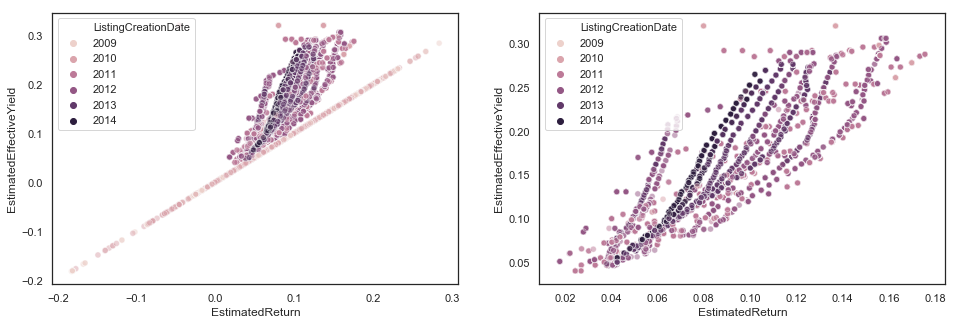

In [47]:
fig, ax = plt.subplots(ncols=2, figsize=[16,5])

sns.scatterplot(data=df, x='EstimatedReturn', y='EstimatedEffectiveYield', 
                hue = df.ListingCreationDate.dt.year, alpha = 0.5, ax=ax[0], legend='full')
ax[0].legend(loc='upper left')

sns.scatterplot(data=df[(df.EstimatedReturn!=df.EstimatedEffectiveYield)&(df.EstimatedReturn>0)], 
                x='EstimatedReturn', y='EstimatedEffectiveYield', hue = df.ListingCreationDate.dt.year, 
                alpha = 0.5, ax=ax[1], legend='full')
ax[1].legend(loc='upper left');

Note, since the left hand distribution, including all values, produced this interesting plot, I have added the listing year variable, which appears to fully explain the interesting shape of distribution on the left.

In [48]:
df[df.EstimatedReturn!=df.EstimatedEffectiveYield].ListingCreationDate.dt.year.value_counts()

2013    35413
2012    19556
2011    11442
2014    10734
2010      257
Name: ListingCreationDate, dtype: int64

In [49]:
df[df.EstimatedReturn==df.EstimatedEffectiveYield].ListingCreationDate.dt.year.value_counts()

2010    5273
2009    2178
Name: ListingCreationDate, dtype: int64

On the left chart above, we can see, that for all 2009 loans and for large part of 2010 loans, estimated return did not include estimated loss (and thus estimated return was equal to estimated yield, producing perfect straigh line correlation).

Prosper seems to have corrected this error in computing Estimated Returns in late 2010.

Follwoing this, estimated return and estimated yield correlate positively, but not perfectly. 

In addition, we can observe increasing steepness in "yearly" cohort of loans, which could be a result of increasing estimated losses (for like for like estimated yields) for each "yearly" cohort.

Below investigate relationship between estimated yield and loss.

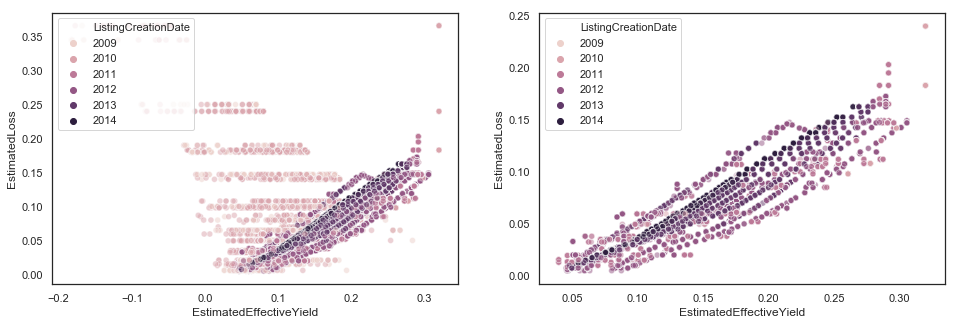

In [50]:
fig, ax = plt.subplots(ncols=2, figsize=[16,5])

sns.scatterplot(data=df, x='EstimatedEffectiveYield', y='EstimatedLoss', 
                hue = df.ListingCreationDate.dt.year, alpha = 0.5, ax=ax[0], legend='full')
ax[0].legend(loc='upper left')


sns.scatterplot(data=df[(df.EstimatedReturn!=df.EstimatedEffectiveYield)&(df.EstimatedReturn>0)], 
                x='EstimatedEffectiveYield', y='EstimatedLoss', hue = df.ListingCreationDate.dt.year, 
                alpha = 0.5, ax=ax[1], legend='full')
ax[1].legend(loc='upper left');

In [51]:
df[df.EstimatedReturn!=df.EstimatedEffectiveYield][['EstimatedReturn','EstimatedEffectiveYield','EstimatedLoss']].corr()

EstimatedReturn  EstimatedEffectiveYield  \
EstimatedReturn                 1.000000                 0.888137   
EstimatedEffectiveYield         0.888137                 1.000000   
EstimatedLoss                   0.718346                 0.957712   

                         EstimatedLoss  
EstimatedReturn               0.718346  
EstimatedEffectiveYield       0.957712  
EstimatedLoss                 1.000000

Again, due to interesting pattern on the left (where a clear policy shift is clear), I added the listing year variable.

From above left chart it appears that in 2009-2010 the estimated loss whas independed of the estimated yield, and fell into several cohorts according to some other variable, following this the estimated loss became linearly related to estimated yield (achiving correlation of 0.96), and year after year the loss proportion appears to be slightly higher (as "yearly" curves shift parallely upwards).

Because:
- estimated yield and estimated loss are highly learnearly correlated (and after 2011 nearly perfectly so), and 
- it appears that one (losses) are a proportion of another (yield), and
- estimated returns is a subtraction of estimated yield and loss, and therefore also linearly related to estimated yield, 

in further investigations I will use estimated yield as proxy for investigating relationships with other variables, unless specific case required otherwise. 

#### How did estimated effective yield (and loss) of loans evolve over time?

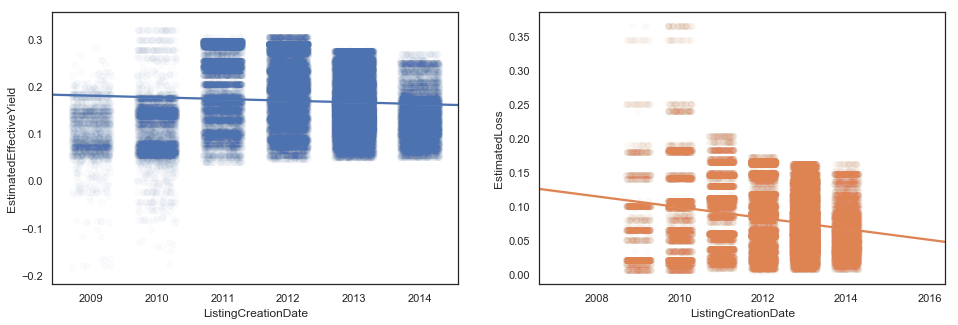

In [45]:
fig, ax = plt.subplots(ncols=2, figsize=[16,5])


sns.regplot(x = df.ListingCreationDate.dt.year, y = df.EstimatedEffectiveYield, 
           fit_reg = True, x_jitter= 0.3, scatter_kws= {'alpha' : 1/50}, ax = ax[0])

sns.regplot(x = df.ListingCreationDate.dt.year, y = df.EstimatedLoss, 
           fit_reg = True, x_jitter= 0.3, scatter_kws= {'alpha' : 1/50}, ax = ax[1]);

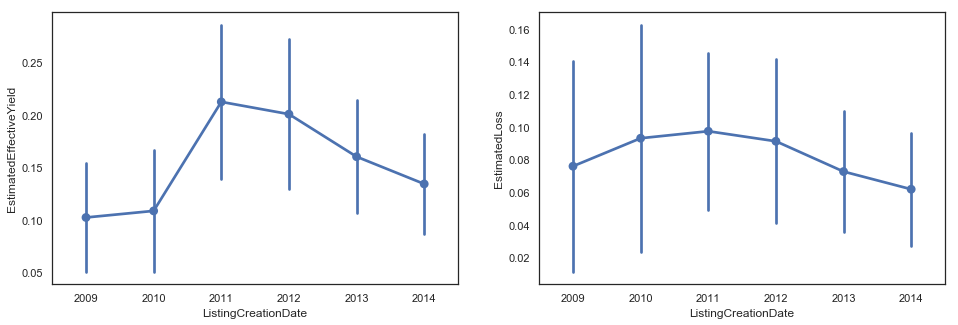

In [46]:
fig, ax = plt.subplots(ncols=2, figsize=[16,5])

sns.pointplot(x = df.ListingCreationDate.dt.year, y = df.EstimatedEffectiveYield, ci = 'sd',ax = ax[0])
sns.pointplot(x = df.ListingCreationDate.dt.year, y = df.EstimatedLoss, ci = 'sd', ax = ax[1]);

Estimated yield loss were lower in 2009 and 2010, then significant upward adjustment followed in 2011, following which, both have steadly declined, though the decline of estimated yield (from 2011 to 2014) was sharper than that of estimated loss in the same period.  

The regplot charts above also illustrate that there were more loans listed/issued after 2011, and that they had what appears a higher density of distribution.

Further, it appears that all the negative yield loans are from 2009/2010 cohorts.

** Since all negative yield loans appeared in limited range period (2009/2010), and were only 190 in number, in some of the following analysis, I exclude these observations. **

In [88]:
df_postitive_yield=df[df.EstimatedEffectiveYield>0]

#### How do borrowers' delinquencies (over last 7 years) and inquiries relate to estimated yield?

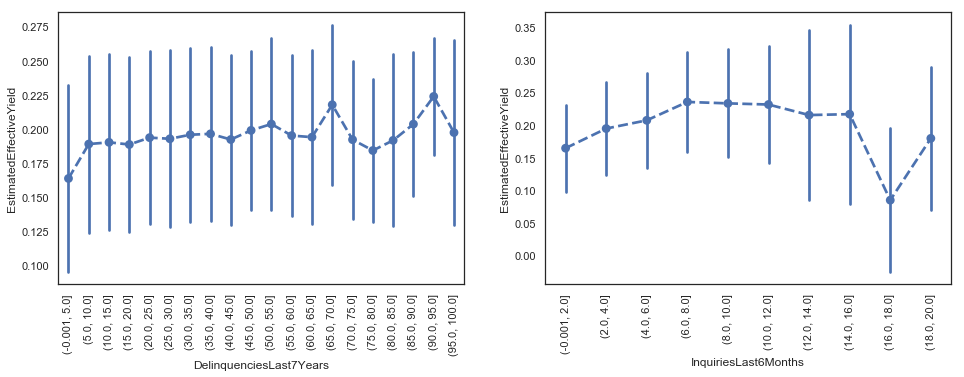

In [87]:
fig, ax = plt.subplots(ncols=2,figsize=[16,5])

del_bins = np.arange(0, 100 + 5, 5)
delinq7yr_bins = pd.cut(df.DelinquenciesLast7Years, del_bins, include_lowest = True)
sns.pointplot(x = delinq7yr_bins, y = df.EstimatedEffectiveYield, ci = 'sd', 
              linestyles='--', ax=ax[0])

inq_bins = np.arange(0, 20 + 2, 2)
inquiries_bins = pd.cut(df.InquiriesLast6Months, inq_bins, include_lowest = True)
sns.pointplot(x = inquiries_bins, y = df.EstimatedEffectiveYield, ci = 'sd', 
              linestyles='--', ax=ax[1])

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90);

More delinquncies (over the last 7 years) appear to result in only mildly higher yields, with exception of "step up" from [0-5] range to higher ranges. It's interesting to look closer at this, as I would expect a steeper positive correlation between delinquencies and estimated yield (and loss).

Greater number of inquiries appears to correlate with higher estimated yields, but the direction of this relationship starts to break down (and is flat) from 6 enquiries onwards, and is reversed after 16 enquiries, which is counterintuitive. 

I will investigate both further in multivariate analysis.

#### How does bank credit availability relates to estimated yield?

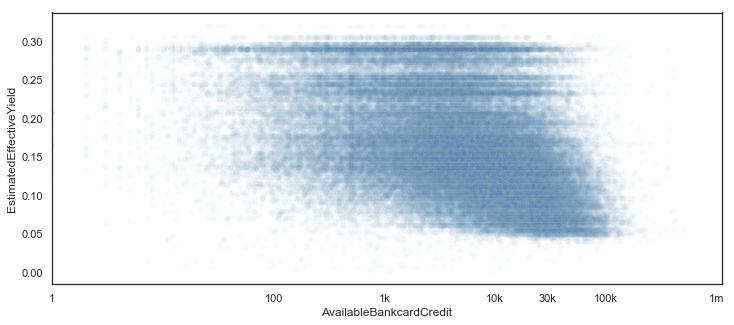

In [89]:
plt.figure(figsize=[12,5])

sns.scatterplot(x=df_postitive_yield.AvailableBankcardCredit, y=df_postitive_yield.EstimatedEffectiveYield, 
                alpha = 0.03, color='steelblue')
plt.xscale('log')
plt.xticks([1,100,1000,10000,30000, 100000,1000000],[1,100,'1k','10k','30k','100k','1m']);

There appears to be negative correlation between available credit, that can be further investigated looking at available credit ranges.

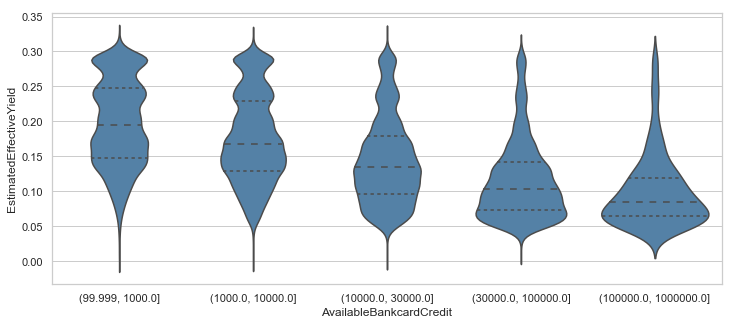

In [90]:
sns.set(style='whitegrid')
plt.figure(figsize=[12,5])

AvailableBankCredit_bins = pd.cut(df_postitive_yield.AvailableBankcardCredit, [100,1000,10000,30000, 100000,1000000], 
                                  include_lowest = True)

sns.violinplot(x=AvailableBankCredit_bins, y=df_postitive_yield.EstimatedEffectiveYield, color='steelblue',
              inner='quartile');

Above chart illustrates more clearly the negative correlation between estimated yield and available bank credit.  This is intuitive, because either available credit indicates banks willingness to lend to a client or that the client hasn't used up it's credit.

The estimated yield is much lower between opposite spectrum of avaible credit ranges, where median yield for first bucket (USD 100-1000) is about 20% and median yield for last two buckets (USD 30k to 100k and USD 100k to 1m) is about 10% and 8% respectively.

#### How does credit score relate to estimated yield?

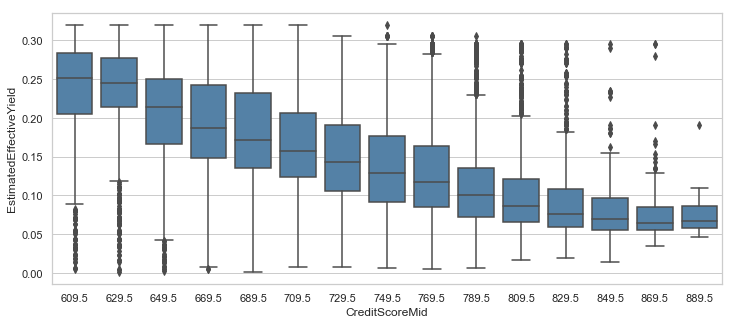

In [56]:
plt.figure(figsize=[12,5])

sns.boxplot(x=df_postitive_yield.CreditScoreMid, y=df_postitive_yield.EstimatedEffectiveYield, color='steelblue');

Credit score, as supplied by external credit agencies to Prosper, appears to have significant negative correlation with estimated yield.  This is to say that higher credit score is lined with lower loan yields. 

#### How does debt to income ratio relate to estimated yield?

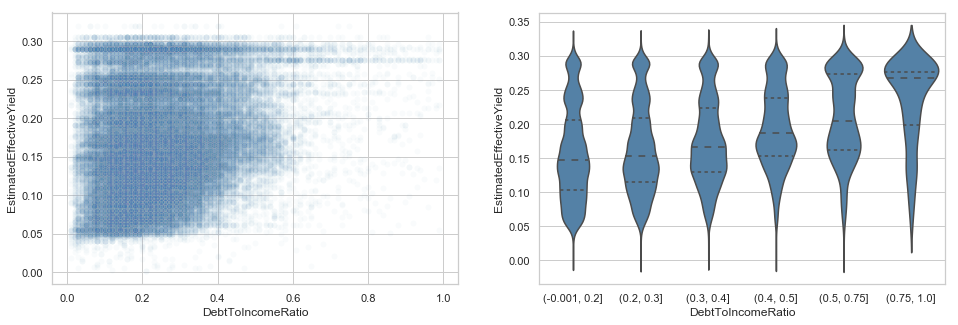

In [57]:
fit, ax = plt.subplots(ncols=2, figsize=[16,5])

df_temp = df_postitive_yield[(df_postitive_yield.DebtToIncomeRatio>0)&(df_postitive_yield.DebtToIncomeRatio<1)]

sns.scatterplot(x=df_temp.DebtToIncomeRatio, y=df_temp.EstimatedEffectiveYield, 
                alpha = 0.03, color='steelblue', ax=ax[0])

DebtToIncome_bins = pd.cut(df_temp.DebtToIncomeRatio, [0,0.2,0.3,0.4,0.5,0.75,1], 
                                  include_lowest = True)

sns.violinplot(x=DebtToIncome_bins, y=df_temp.EstimatedEffectiveYield, color='steelblue',
              inner='quartile');

Debt to income ratio appears to have a positive correlation with estimated yield.  This is to say that higher debt to income ratio ("higher indebtidness") leads to higher estimated yields.  This relationship is muted for lower debt to income ratio buckets, but emerges more clearly as debt to income ration exceeds 0.3, and is especially pronounced when it moves above 0.75. 

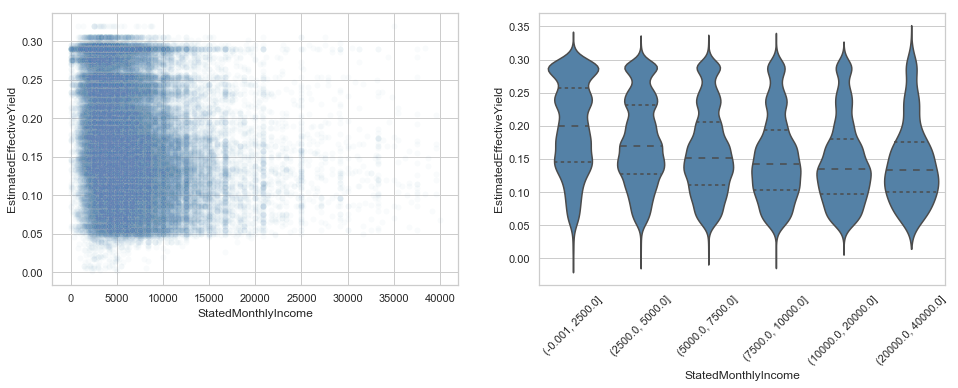

In [58]:
fit, ax = plt.subplots(ncols=2, figsize=[16,5])

df_temp = df_postitive_yield[(df_postitive_yield.StatedMonthlyIncome>0)&(df_postitive_yield.StatedMonthlyIncome<40000)]

sns.scatterplot(x=df_temp.StatedMonthlyIncome, y=df_temp.EstimatedEffectiveYield, 
                alpha = 0.03, color='steelblue', ax=ax[0])

StatedMonthlyIncome_bins = pd.cut(df_temp.StatedMonthlyIncome, [0,2500,5000,7500,10000,20000,40000], 
                                  include_lowest = True)

sns.violinplot(x=StatedMonthlyIncome_bins, y=df_temp.EstimatedEffectiveYield, color='steelblue',
              inner='quartile')
plt.xticks(rotation=45);

Stated monthly income appears to have a negative correlation with estimated yield.  This is to say that higher monthly income  leads to lower estimated yields.  This relationship is stronger as income rises from 0 to 7,500 a month, then relashionship weakens for monthly income exceeding 7,500.

#### How does home ownership relate to estimated yield?

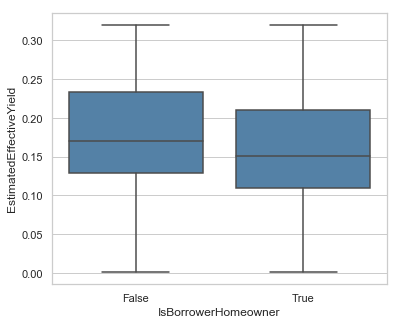

In [59]:
plt.figure(figsize=[6,5])

sns.boxplot(x=df_postitive_yield.IsBorrowerHomeowner, y=df_postitive_yield.EstimatedEffectiveYield, 
            color='steelblue');

People owning homes appear to borrow at slighlty lower yiels (median and interquartile range boundries are lower), however, the overall range is about the same.

#### How does occupation relate to estimated yield?

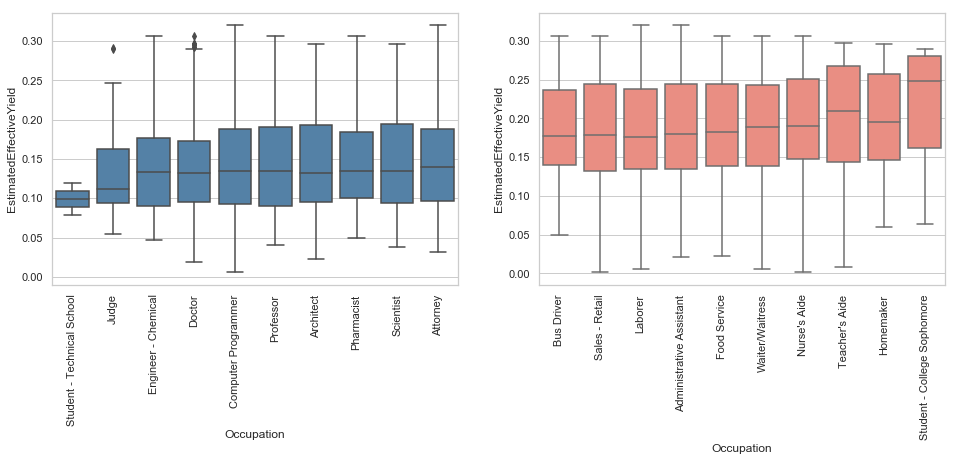

In [60]:
fix, ax=plt.subplots(ncols=2, figsize=[16,5])

occupation_lowyield = df_postitive_yield.groupby('Occupation')['EstimatedEffectiveYield'].mean().sort_values().head(10).index
occupation_highyield = df_postitive_yield.groupby('Occupation')['EstimatedEffectiveYield'].mean().sort_values().tail(10).index

df_temp_low = df_postitive_yield[df_postitive_yield.Occupation.isin(occupation_lowyield)]
df_temp_high = df_postitive_yield[df_postitive_yield.Occupation.isin(occupation_highyield)]

sns.boxplot(x=df_temp_low.Occupation, y=df_temp_low.EstimatedEffectiveYield, 
            color='steelblue', order=occupation_lowyield, ax=ax[0])
ax[0].set_xticklabels(occupation_lowyield, rotation=90)

sns.boxplot(x=df_temp_high.Occupation, y=df_temp_high.EstimatedEffectiveYield, 
            color='salmon', order=occupation_highyield, ax=ax[1])
ax[1].set_xticklabels(occupation_highyield, rotation=90);

Looking at occupations related to lowest average yields, and occupations related to highers average yields, there does appear to be a relationship between these variables.

Typically higher earning, requiring extensive education, more "elite" professions appear to be related to lower yields (though range is high),  and professions requiring lower education, likely to be more temporary basis appear to be related with higher yields.

Note, even a technical student (though as yet not earning) appears to have access to low yield loan.

Below I test how these occupations related to stated monthly income.

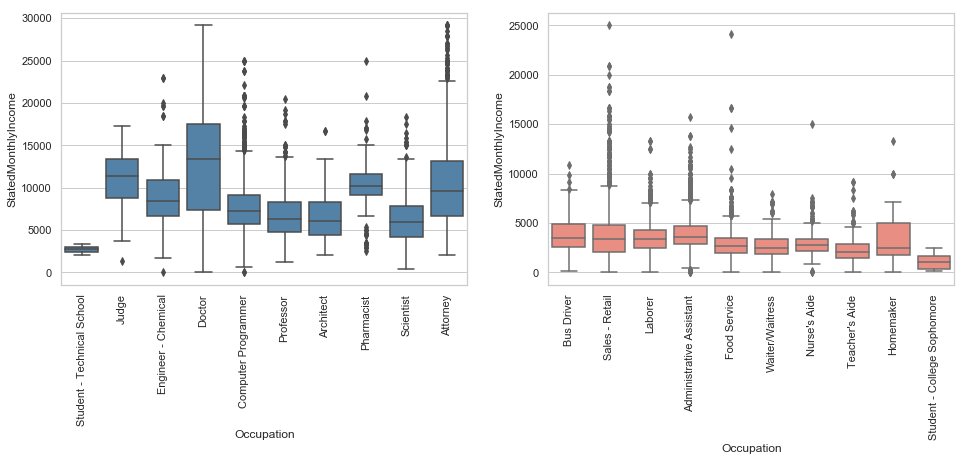

In [61]:
fix, ax=plt.subplots(ncols=2, figsize=[16,5])

mask_low = df_temp_low.StatedMonthlyIncome<30000
mask_high = df_temp_high.StatedMonthlyIncome<30000

sns.boxplot(x=df_temp_low[mask_low].Occupation, y=df_temp_low[mask_low].StatedMonthlyIncome, 
            color='steelblue', order=occupation_lowyield, ax=ax[0])
ax[0].set_xticklabels(occupation_lowyield, rotation=90)

sns.boxplot(x=df_temp_high[mask_high].Occupation, y=df_temp_high[mask_high].StatedMonthlyIncome, 
            color='salmon', order=occupation_highyield, ax=ax[1])
ax[1].set_xticklabels(occupation_highyield, rotation=90);

Though occupations commanding lowest average yields do not uniformly command very high monthly incomes, the incomes of occupations having access to low yields are clearly higher (and 3/4 of instances earn *above* USD 5,000) than of those occupations commanding highest average yields (who without exception have 3/4 of instances earn *below* 5,000).

#### How does loan amount relate to estimated yield and to credit score?

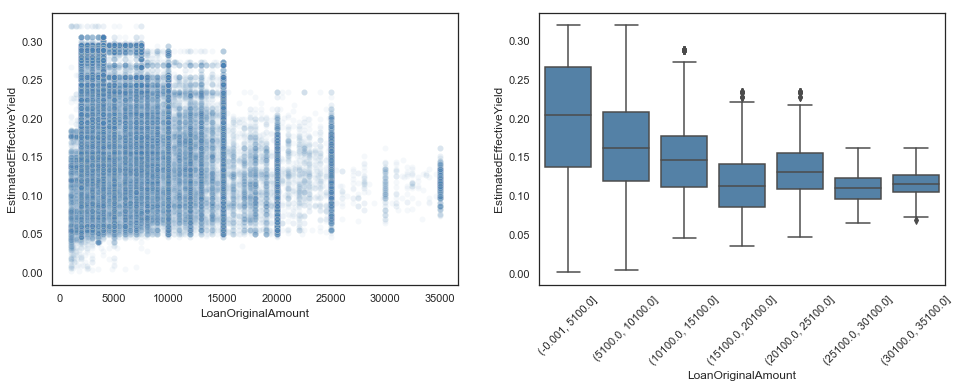

In [62]:
sns.set(style='white')

fit, ax = plt.subplots(ncols=2, figsize=[16,5])

sns.scatterplot(x=df_postitive_yield.LoanOriginalAmount, y=df_postitive_yield.EstimatedEffectiveYield, 
                alpha = 0.05, color='steelblue', ax=ax[0])

OriginalLoanAmount_bins = pd.cut(df_postitive_yield.LoanOriginalAmount, [0,5100,10100,15100,
                                                                         20100,25100,30100,35100], include_lowest = True)

sns.boxplot(x=OriginalLoanAmount_bins, y=df_postitive_yield.EstimatedEffectiveYield, color='steelblue', ax=ax[1])
plt.xticks(rotation=45);

As previously observed, there are "concentrations" around loand at 5k, 10k, 15k, 20k, 25k, 30k, 35k level.

Furthermore, there appear to be visibly less loans in general that are 20k and larger.

The small loans appear to have a large range in yields, and that yield range decreases as loan sizes increase.

There appear to be no large loans issued above a certain yield level.  This is something to be investigated below and in multivariate analysis.  Hypothesis is that large loans are also only given to high income, high credit score borrowers, hence the yields are lower.

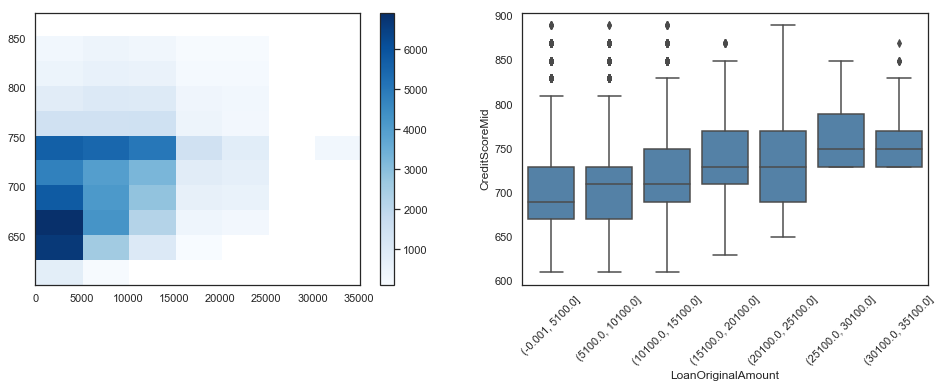

In [63]:
fig, ax = plt.subplots(ncols=2, figsize=[16,5])

loan_bins = [0,5100,10100,15100,20100,25100,30100,35100]
creditscore_bins = np.arange(601,901,25)

h = ax[0].hist2d(x=df_postitive_yield.LoanOriginalAmount, y=df_postitive_yield.CreditScoreMid, 
             bins=[loan_bins,creditscore_bins], cmap="Blues", cmin = 100)
plt.colorbar(h[3], ax=ax[0])

OriginalLoanAmount_bins = pd.cut(df_postitive_yield.LoanOriginalAmount, bins=loan_bins, include_lowest = True)

sns.boxplot(x=OriginalLoanAmount_bins, y=df_postitive_yield.CreditScoreMid, color='steelblue', ax=ax[1])
plt.xticks(rotation=45);

Above charts illustrate that more loans are issued of lower overall amounts, and that there is very high frequncy of smaller loans to borrowers with credit scores ranaging from 600 to 750.

Then it appears that as loan amounts increase, the borrower's credit ratings also increase, to the extent that loans above USD 25,000 are not issued to anyone with credit score lower than about 725.

#### How does loan status relate to estimated loss and actual loss?

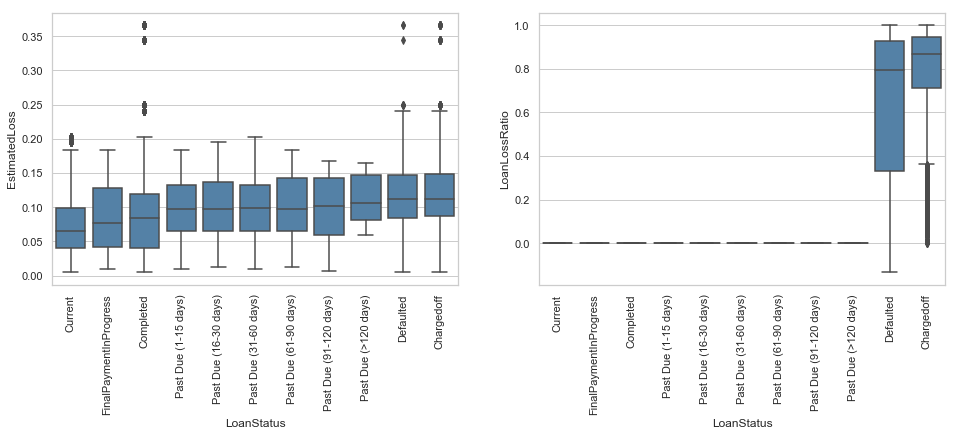

In [64]:
sns.set(style='whitegrid')

fig, ax = plt.subplots(ncols=2, figsize=[16,5])

sns.boxplot(x=df.LoanStatus, y=df.EstimatedLoss, color='steelblue', ax=ax[0])
sns.boxplot(x=df.LoanStatus, y=df.LoanLossRatio, color='steelblue', ax=ax[1])

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90);

Overall, it appears that current laons, and loans with final payment in progress, have lower estimated losses, than those that are past due or indeed defaulted or chargedoff.

Nonetheless, actual loss ratio, which occurs only in defaulted and chargedoff loans (as indicated by chart above right), is far higher, with median reaching about 80% and 90% respectively of the original amount of the loan.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

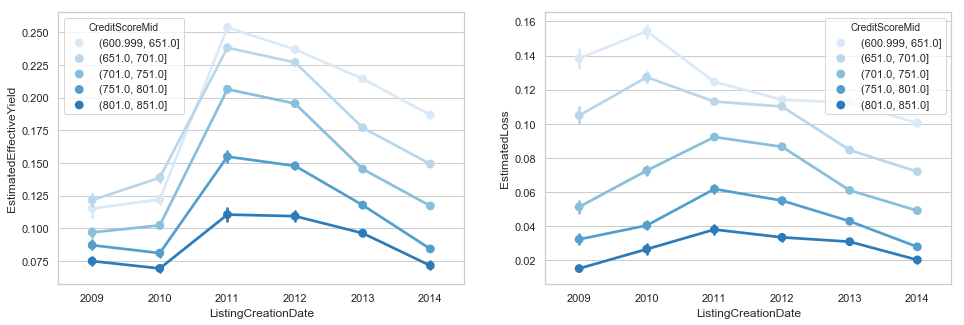

In [65]:
cred_bins = np.arange(601,901,50)

creditscore_bins = pd.cut(df.CreditScoreMid, cred_bins, include_lowest = True)
creditscore_index= creditscore_bins.value_counts().sort_index().index

fig, ax = plt.subplots(ncols=2, figsize=[16,5])
palette = sns.color_palette("Blues")

sns.pointplot(x = df.ListingCreationDate.dt.year, y = df.EstimatedEffectiveYield, 
              hue = creditscore_bins, 
              ax = ax[0], palette=palette)
sns.pointplot(x = df.ListingCreationDate.dt.year, y = df.EstimatedLoss, 
              hue = creditscore_bins,
              ax = ax[1], palette=palette);

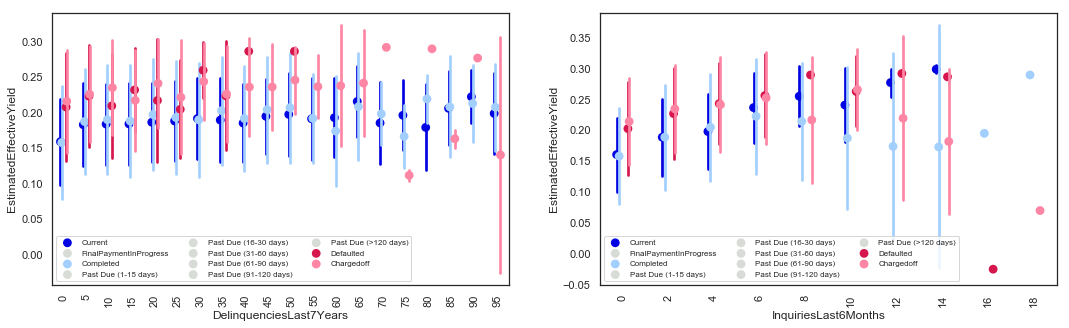

In [53]:
status_list = ['Current', 'Completed', 'Defaulted', 'Chargedoff'] 

df_small = df[df.LoanStatus.isin(status_list)]

fig, ax = plt.subplots(ncols=2,figsize=[18,5])
colors = ['pure blue', 'light grey', 'baby blue', 'light grey', 'light grey', 
          'light grey', 'light grey', 'light grey', 'light grey',
          'lipstick', 'rosa']
palette = sns.xkcd_palette(colors)

del_bins = np.arange(0, 100 + 5, 5)
delinq7yr_bins = pd.cut(df_small.DelinquenciesLast7Years, del_bins, include_lowest = True)
sns.pointplot(x = delinq7yr_bins, y = df_small.EstimatedEffectiveYield, hue=df_small.LoanStatus,
              ci = 'sd', linestyles='', ax=ax[0], dodge=True, palette=palette)
ax[0].set_xticklabels(labels=del_bins,rotation = 90)
ax[0].legend(ncol=3,loc='lower left', fontsize=8)

inq_bins = np.arange(0, 20 + 2, 2)
inquiries_bins = pd.cut(df_small.InquiriesLast6Months, inq_bins, include_lowest = True)
sns.pointplot(x = inquiries_bins, y = df_small.EstimatedEffectiveYield, hue=df_small.LoanStatus, 
              ci = 'sd', linestyles='', ax=ax[1], dodge=True, palette=palette)
ax[1].set_xticklabels(labels=inq_bins,rotation = 90)
ax[1].legend(ncol=3,loc='lower left', fontsize=8);

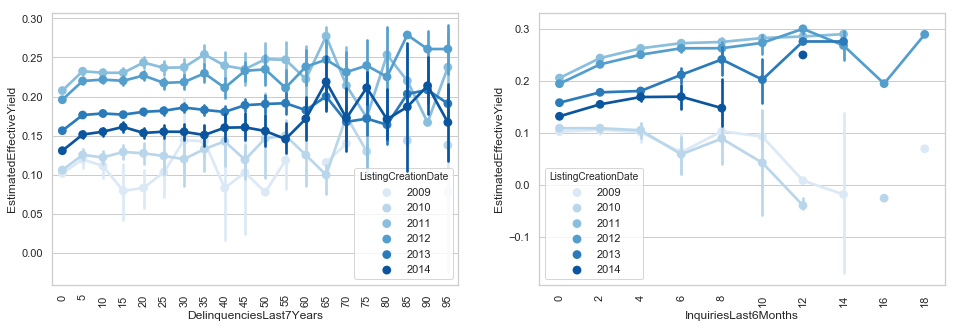

In [66]:
fig, ax = plt.subplots(ncols=2,figsize=[16,5])

palette = sns.color_palette("Blues")

del_bins = np.arange(0, 100 + 5, 5)
delinq7yr_bins = pd.cut(df.DelinquenciesLast7Years, del_bins, include_lowest = True)
sns.pointplot(x = delinq7yr_bins, y = df.EstimatedEffectiveYield, 
              hue = df.ListingCreationDate.dt.year, 
              ax=ax[0], palette=palette)
ax[0].set_xticklabels(labels=del_bins,rotation = 90)

inq_bins = np.arange(0, 20 + 2, 2)
inquiries_bins = pd.cut(df.InquiriesLast6Months, inq_bins, include_lowest = True)
sns.pointplot(x = inquiries_bins, y = df.EstimatedEffectiveYield, 
              hue = df.ListingCreationDate.dt.year, 
              ax=ax[1], palette=palette)
ax[1].set_xticklabels(labels=inq_bins,rotation = 90);

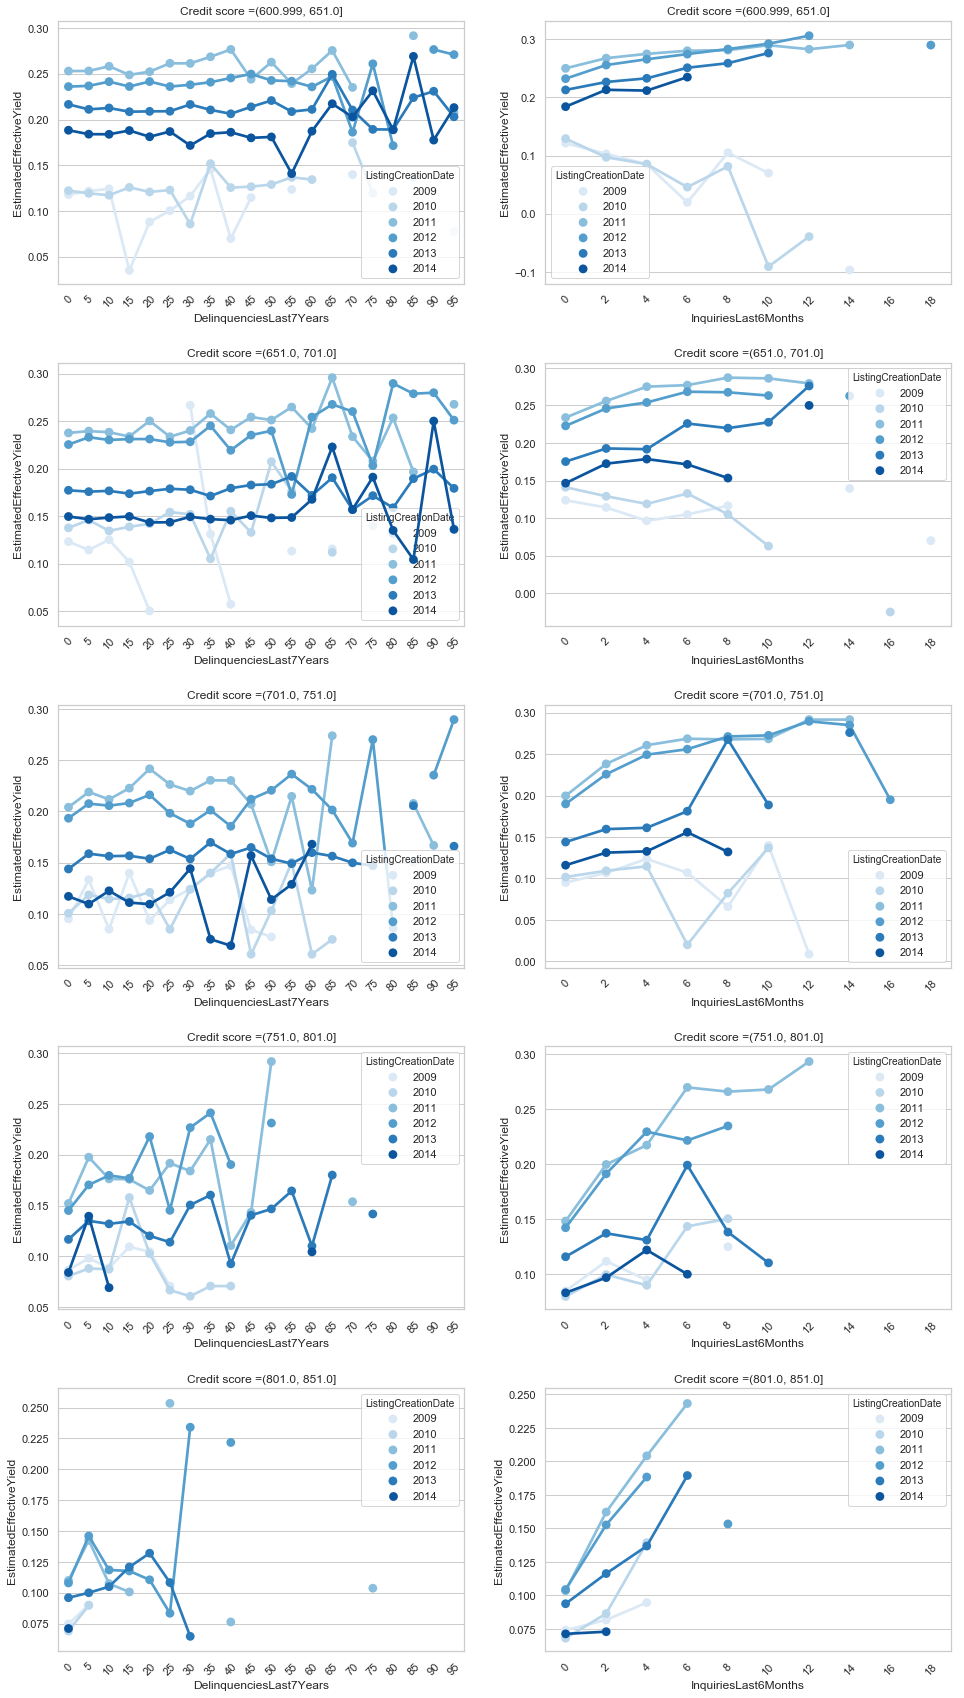

In [67]:
del_bins = np.arange(0, 100 + 5, 5)
inq_bins = np.arange(0, 20 + 2, 2)
cred_bins = np.arange(601,901,50)

creditscore_bins = pd.cut(df.CreditScoreMid, cred_bins, include_lowest = True)
creditscore_index= creditscore_bins.value_counts().sort_index().index

fig, ax = plt.subplots(nrows =len(creditscore_index), ncols=2,figsize=[16,30])

palette = sns.color_palette("Blues")

row = 0

for credit_score in creditscore_index:  
    
    df_credit = df[creditscore_bins == credit_score]
    
    delinq7yr_bins = pd.cut(df_credit.DelinquenciesLast7Years, del_bins, include_lowest = True)  
    sns.pointplot(x = delinq7yr_bins, y = df_credit.EstimatedEffectiveYield, hue = df_credit.ListingCreationDate.dt.year, 
                  ax=ax[row,0], palette=palette, ci=None)
    ax[row,0].set_xticklabels(labels=del_bins,rotation = 45)
    ax[row,0].title.set_text('Credit score ={}'.format(credit_score))
    
    inquiries_bins = pd.cut(df_credit.InquiriesLast6Months, inq_bins, include_lowest = True)
    sns.pointplot(x = inquiries_bins, y = df_credit.EstimatedEffectiveYield, hue = df_credit.ListingCreationDate.dt.year, 
                  ax=ax[row,1], palette=palette, ci=None)
    ax[row,1].set_xticklabels(labels=inq_bins,rotation = 45)
    ax[row,1].title.set_text('Credit score ={}'.format(credit_score))
    
    row +=1
    
plt.subplots_adjust(hspace=0.3);

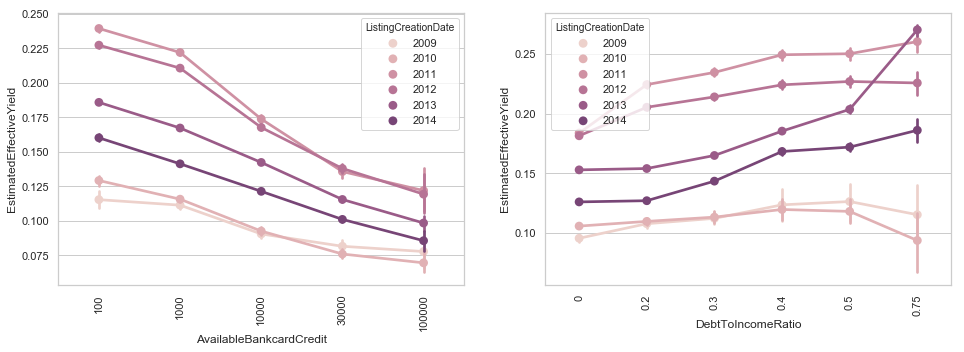

In [68]:
fig, ax = plt.subplots(ncols=2,figsize=[16,5])

palette = sns.cubehelix_palette(8)

ABC_bins = [100,1000,10000,30000, 100000,1000000]
AvailableBankCredit_bins = pd.cut(df.AvailableBankcardCredit, ABC_bins, 
                                  include_lowest = True)
sns.pointplot(x = AvailableBankCredit_bins, y = df.EstimatedEffectiveYield, 
              hue = df.ListingCreationDate.dt.year, 
              ax=ax[0], palette=palette)
ax[0].set_xticklabels(labels=ABC_bins,rotation = 90)

DTI_bins = [0,0.2,0.3,0.4,0.5,0.75,1]
DebtToIncome_bins = pd.cut(df.DebtToIncomeRatio, DTI_bins, 
                                  include_lowest = True)
sns.pointplot(x = DebtToIncome_bins, y = df.EstimatedEffectiveYield, 
              hue = df.ListingCreationDate.dt.year, 
              ax=ax[1], palette=palette)
ax[1].set_xticklabels(labels=DTI_bins,rotation = 90);

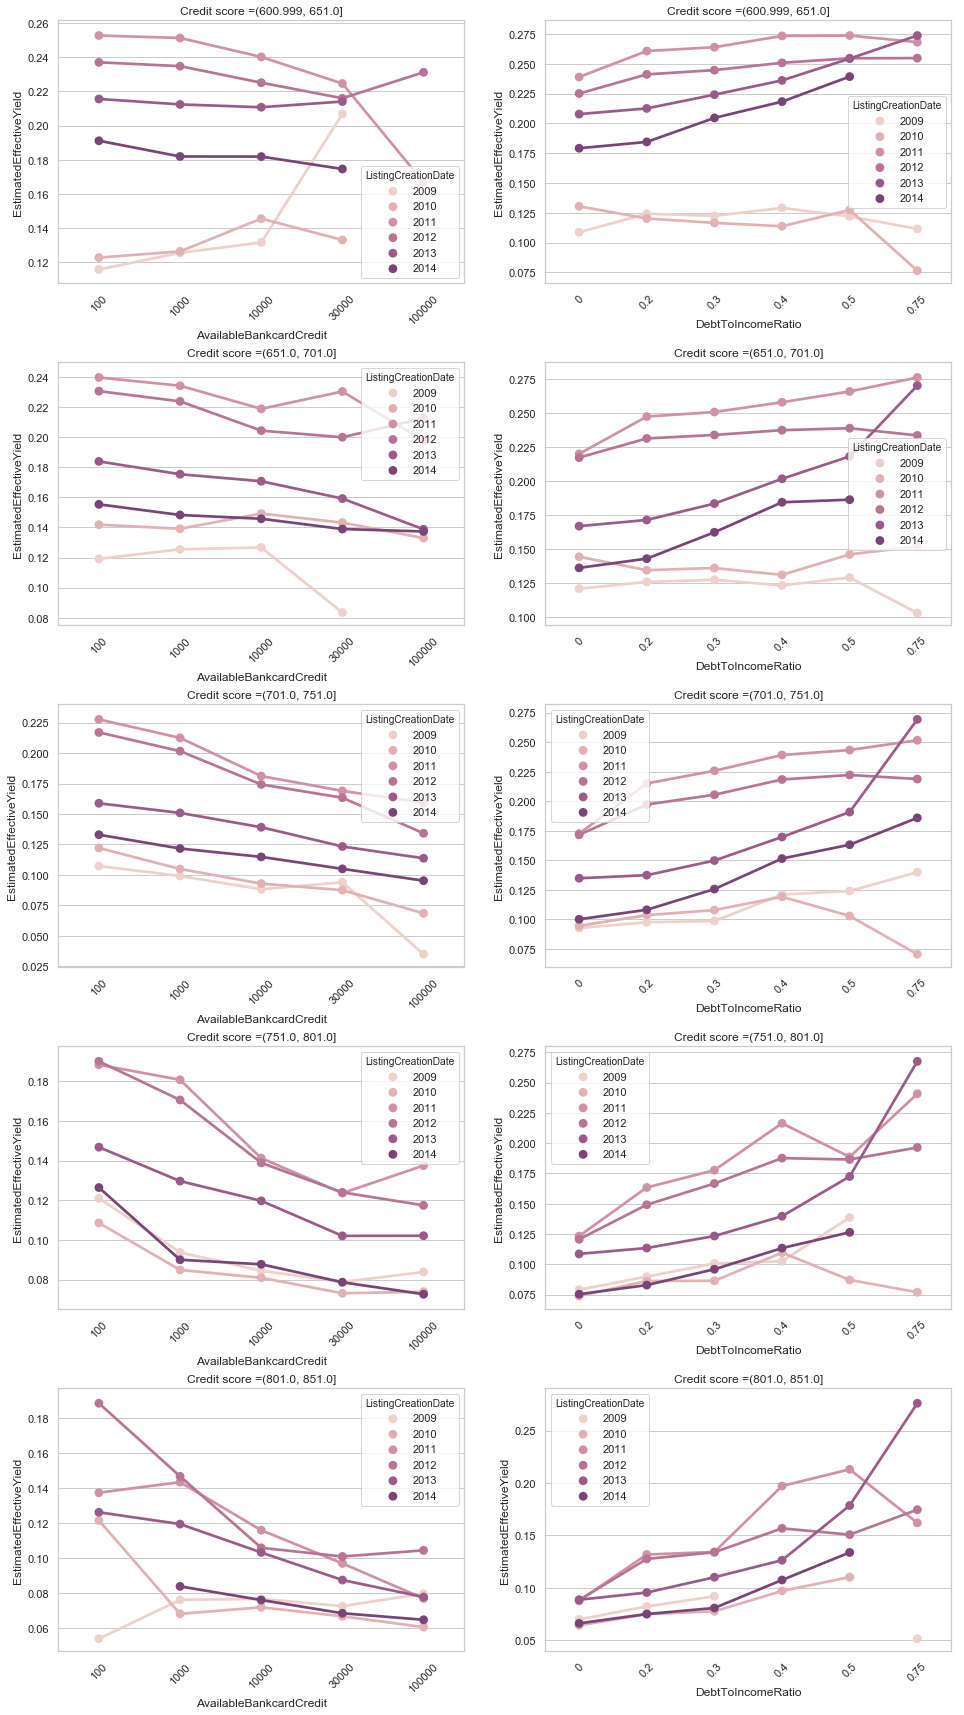

In [69]:
ABC_bins = [100,1000,10000,30000, 100000,1000000]
DTI_bins = [0,0.2,0.3,0.4,0.5,0.75,1]
cred_bins = np.arange(601,901,50)

creditscore_bins = pd.cut(df.CreditScoreMid, cred_bins, include_lowest = True)
creditscore_index= creditscore_bins.value_counts().sort_index().index

fig, ax = plt.subplots(nrows =len(creditscore_index), ncols=2,figsize=[16,30])

palette = sns.cubehelix_palette(8)

row = 0

for credit_score in creditscore_index:  
    
    df_credit = df[(creditscore_bins == credit_score)]
    AvailableBankCredit_bins = pd.cut(df_credit.AvailableBankcardCredit, ABC_bins, include_lowest = True)
    sns.pointplot(x = AvailableBankCredit_bins, y = df_credit.EstimatedEffectiveYield, 
                  hue = df_credit.ListingCreationDate.dt.year, 
                  ax=ax[row,0], palette=palette, ci=False)
    ax[row,0].set_xticklabels(labels=ABC_bins,rotation = 45)
    ax[row,0].title.set_text('Credit score ={}'.format(credit_score))
    
    DebtToIncome_bins = pd.cut(df_credit.DebtToIncomeRatio, DTI_bins, include_lowest = True)
    sns.pointplot(x = DebtToIncome_bins, y = df_credit.EstimatedEffectiveYield, 
                  hue = df_credit.ListingCreationDate.dt.year, 
                  ax=ax[row,1], palette=palette, ci=False)
    ax[row,1].set_xticklabels(labels=DTI_bins,rotation = 45)
    ax[row,1].title.set_text('Credit score ={}'.format(credit_score))
    
    row +=1
    
plt.subplots_adjust(hspace=0.3);

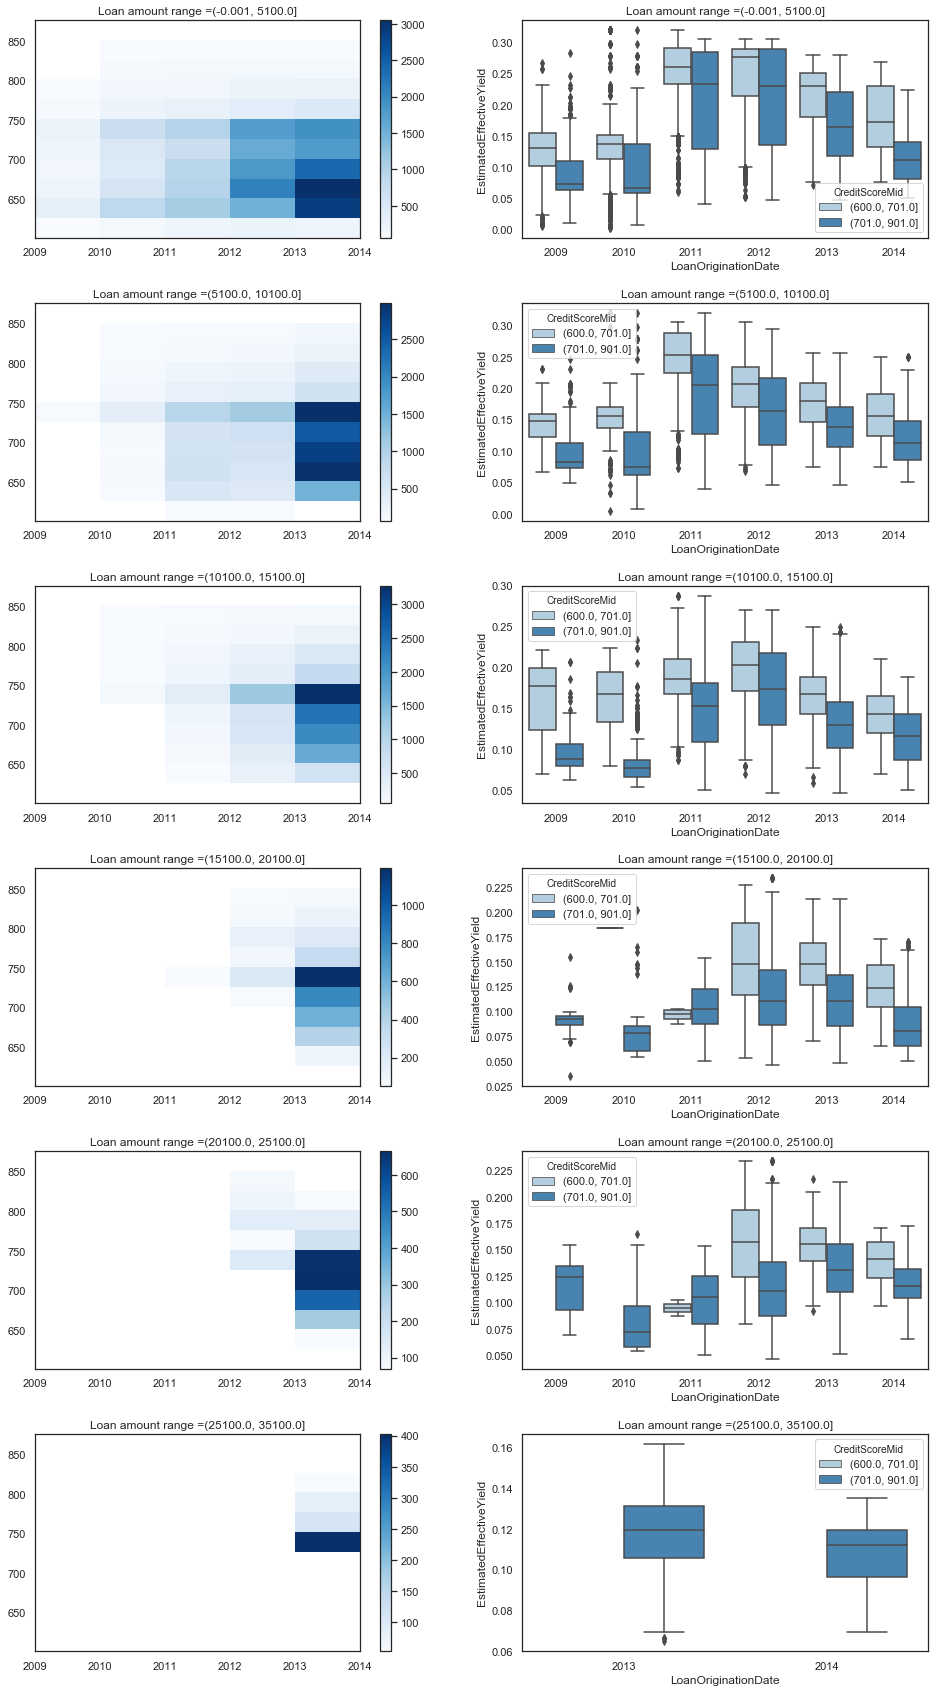

In [70]:
sns.set(style='white')

years=df_postitive_yield.LoanOriginationDate.dt.year.value_counts().sort_index().index
loan_bins = [0,5100,10100,15100,20100,25100,35100]
creditscore_bins = np.arange(601,901,25)
creditscore_largebins = [600.001,701,901]

OriginalLoanAmount_bins = pd.cut(df_postitive_yield.LoanOriginalAmount, bins=loan_bins, include_lowest = True)
OriginalLoanAmount_index=OriginalLoanAmount_bins.value_counts().sort_index().index

rows = len(OriginalLoanAmount_index)


fig, ax = plt.subplots(nrows = rows, ncols=2, figsize=[16, rows*5])

row = 0
for loan_amount in OriginalLoanAmount_index:
    
    mask = (OriginalLoanAmount_bins == loan_amount)
    
    h = ax[row,0].hist2d(x=df_postitive_yield[mask].LoanOriginationDate.dt.year, 
                         y=df_postitive_yield[mask].CreditScoreMid, 
                         bins=[years,creditscore_bins], cmap="Blues", cmin = 50)
    plt.colorbar(h[3], ax=ax[row,0])
    ax[row,0].title.set_text('Loan amount range ={}'.format(loan_amount))

    CreditScore_large_bins = pd.cut(df_postitive_yield[mask].CreditScoreMid, bins=creditscore_largebins, 
                                    include_lowest = True)
    sns.boxplot(x=df_postitive_yield[mask].LoanOriginationDate.dt.year, 
                y=df_postitive_yield[mask].EstimatedEffectiveYield, 
                hue=CreditScore_large_bins,
                palette='Blues', ax=ax[row,1])
    ax[row,1].title.set_text('Loan amount range ={}'.format(loan_amount))
    
    row +=1
    
plt.subplots_adjust(hspace=0.3);

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!